## Connect to Local Runtime
jupyter notebook --NotebookApp.allow_origin='https://colab.research.google.com' --port=8888 --NotebookApp.port_retries=0

In [1]:
!nvidia-smi

Sun Jan  9 17:08:09 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 496.49       Driver Version: 496.49       CUDA Version: 11.5     |
|-------------------------------+----------------------+----------------------+
| GPU  Name            TCC/WDDM | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ... WDDM  | 00000000:01:00.0  On |                  N/A |
| 16%   36C    P8    34W / 250W |   1526MiB / 11264MiB |      2%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
import os
import sys
import numpy as np
import tensorflow as tf
import tensorflow_io as tfio
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow_addons import layers as addon_layers
import importlib

# Librosa (the mother of audio files)
import librosa
import librosa.display
import IPython.display as ipd
import matplotlib.pyplot as plt

In [3]:
print(tf.__version__)
# print(addon_layers.__version__)

2.7.0


In [4]:
def assert_shape(x, exp_shape):
    assert x.shape == exp_shape, f"Expected {exp_shape} got {x.shape}"

In [5]:
# Import Project Modules
module_path = os.path.abspath(os.path.join('.')) + "\\Documents\\GitHub\\VAE-based-Music--Deep-Generative-Models"
print(f"Project module absolute path: {module_path}")
if module_path not in sys.path:
  sys.path.append(module_path)

Project module absolute path: C:\Users\Zeyu Sun\Documents\GitHub\VAE-based-Music--Deep-Generative-Models


In [39]:
import resnet
import data_utils
import encdec
import VectorQuantizer
import vqvae

In [40]:
## Reload Module
importlib.reload(resnet)
importlib.reload(encdec)
importlib.reload(VectorQuantizer)
importlib.reload(data_utils)
importlib.reload(vqvae)

<module 'vqvae' from 'C:\\Users\\Zeyu Sun\\Documents\\GitHub\\VAE-based-Music--Deep-Generative-Models\\vqvae.py'>

In [8]:
## Test Module Import
# test_res1dblock = resnet.ResnetConv1DBlock(kernel_size=3, filters=32)
test_dilated_res_stack = resnet.DilatedResnet1D(32, 3, dilation_factor=3, reverse_dilation=True)

## DataSet

In [ ]:
## Local Data-path
DATA_PATH = "GENERATIVE_DATA/LJSpeech-1.1/wavs/*.wav"

In [ ]:
# Load in 13100 discrete speech samples (wav files and ignore the audio annotations)
wavs = tf.io.gfile.glob(DATA_PATH)
print(f"Number of audio files: {len(wavs)}")

In [ ]:
3 ** 0

1

### GTZAN

In [9]:
DATA_PATH = "GENERATIVE_DATA/GTZAN/genres_original/"

## Data Loading
### 28160 / 2^(5 + 3) is integer
MAX_SIGNAL_LEN = 28160 #28000 #10240 # 80000

### Compressed 30 s audio
SAMPLE_RATE=  3000 #3000
DURATION= 10

QUANTIZATION_CHANNELS = 256 # 8bit

GENRES = {'metal': 0, 'disco': 1, 'classical': 2, 'rock': 3, 'jazz': 4, 
          'country': 5, 'pop': 6, 'blues': 7, 'reggae': 8, 'hiphop': 9}

In [10]:
# DEV
sample = data_utils.load_audio(DATA_PATH+'hiphop/hiphop.00032.wav', sr=SAMPLE_RATE, duration=DURATION, mono=False)
print("Sample Signal Shape: {}, sample Rate: {}".format(sample.shape, SAMPLE_RATE))
ipd.Audio(sample, rate=SAMPLE_RATE)

Sample Signal Shape: (1, 30001), sample Rate: 3000


0.64707106 -0.67217755


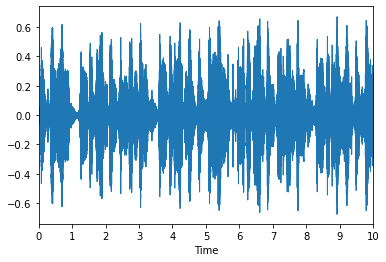

In [11]:
print(np.amax(sample), np.amin(sample))
## Waveplot
librosa.display.waveplot(sample[0], sr=SAMPLE_RATE)

In [12]:
# Read The Data
X_train, y_train, X_test, y_test = data_utils.read_data(DATA_PATH, GENRES, sample_rate=SAMPLE_RATE, duration=DURATION, max_signal_len=MAX_SIGNAL_LEN)

Loading Audio files under Genere: metal
Loading Audio files under Genere: disco
Loading Audio files under Genere: classical
Loading Audio files under Genere: rock
Loading Audio files under Genere: jazz
Skipping file: GENERATIVE_DATA/GTZAN/genres_original/jazz/jazz.00054.wav...
Loading Audio files under Genere: country
Loading Audio files under Genere: pop
Loading Audio files under Genere: blues
Loading Audio files under Genere: reggae
Loading Audio files under Genere: hiphop
Loading and Preprocessing Testing data......
Loading audio file: GENERATIVE_DATA/GTZAN/genres_original/rock/rock.00092.wav...
(1, 1, 28160)
Loading audio file: GENERATIVE_DATA/GTZAN/genres_original/jazz/jazz.00016.wav...
(1, 1, 28160)
Loading audio file: GENERATIVE_DATA/GTZAN/genres_original/disco/disco.00006.wav...
(1, 1, 28160)
Loading audio file: GENERATIVE_DATA/GTZAN/genres_original/metal/metal.00021.wav...
(1, 1, 28160)
Loading audio file: GENERATIVE_DATA/GTZAN/genres_original/hiphop/hiphop.00063.wav...
(1, 1,

In [13]:
print(type(X_train), X_train.shape, X_test.shape, y_train.shape, X_test.shape)

print(y_train[:5])
print(set(y_train), set(y_test))

## Debug Inspect samples
### 2: classical, 9: hip-hop
hiphop_idx = np.where(y_train==2)[0]
print(hiphop_idx[:10])
ipd.Audio(X_train[hiphop_idx[2]], rate=SAMPLE_RATE)
# ipd.Audio(X_train[hiphop_idx[2]], rate=22050) # raw file

<class 'numpy.ndarray'> (899, 1, 28160) (100, 1, 28160) (899,) (100, 1, 28160)
[6 8 8 0 3]
{0, 1, 2, 3, 4, 5, 6, 7, 8, 9} {0, 1, 2, 3, 4, 5, 6, 7, 8, 9}
[ 24  34  53  62  65  73  80  87  98 105]


In [14]:
X_train_T = X_train.transpose([0,2,1]) # (N, T, 1)
X_test_T = X_test.transpose([0, 2, 1])

In [15]:
print(X_train_T.shape, X_test_T.shape)
ipd.Audio(X_train_T[hiphop_idx[2]].flatten(), rate=SAMPLE_RATE)

(899, 28160, 1) (100, 28160, 1)


In [16]:
BATCH_SIZE = 8
TRAIN_SHUFFLE_SIZE = 1000
NUM_GENERES = len(np.unique(y_train))

In [17]:
## Load to TF DataSet (numpy to TF Tensor)
train_dataset = (tf.data.Dataset.from_tensor_slices((X_train_T, y_train))
                 .shuffle(TRAIN_SHUFFLE_SIZE)
                 .batch(BATCH_SIZE))
test_dataset = (tf.data.Dataset.from_tensor_slices((X_test_T, y_test))
                 .batch(BATCH_SIZE))

In [18]:
print(np.amax(X_train_T), np.amin(X_train_T))
# print(np.amax(list(train_dataset.as_numpy_iterator())))

1.25347 -1.2156466


In [19]:
### Example batch
sample_batch, sample_labels = next(iter(train_dataset))
print(sample_batch.shape)
print(sample_labels.shape, sample_labels)
print(sample_batch[0].numpy().squeeze())
print(tf.math.reduce_max(sample_batch).numpy(), tf.math.reduce_min(sample_batch).numpy(), )

(8, 28160, 1)
(8,) tf.Tensor([6 5 5 6 5 7 4 9], shape=(8,), dtype=int32)
[-0.02562967 -0.02848455  0.05142016 ... -0.12503062 -0.21851067
 -0.3965167 ]
1.025513 -1.0227605


####Training Data Samples (1 per genre)

In [20]:
## Multiple Genres Case
idx_to_genres = {v:k for (k, v) in GENRES.items()}
# create a dict of each unique entry and the associated indices
generes_train_idx = {v: np.where(y_train == v)[0].tolist()[:6] for v in np.unique(y_train)}

print(generes_train_idx)

train_samples = []

for i in range(NUM_GENERES):
  train_samples.append(X_train_T[int(generes_train_idx[i][0])])
  # Quantization Version
  # train_samples.append(X_train_Q[int(generes_train_idx[i][0])])

# Numpy Array
train_samples = np.stack(train_samples, axis=0)
print(train_samples.shape, train_samples[0])

{0: [3, 5, 18, 23, 25, 48], 1: [15, 27, 37, 39, 43, 46], 2: [24, 34, 53, 62, 65, 73], 3: [4, 30, 33, 40, 45, 55], 4: [6, 10, 12, 16, 20, 21], 5: [8, 9, 19, 41, 51, 81], 6: [0, 28, 35, 47, 56, 60], 7: [11, 13, 17, 22, 29, 38], 8: [1, 2, 7, 14, 42, 61], 9: [36, 44, 54, 67, 89, 106]}
(10, 28160, 1) [[-0.04690116]
 [-0.01698253]
 [-0.0486879 ]
 ...
 [-0.00471123]
 [-0.02285618]
 [-0.06057921]]


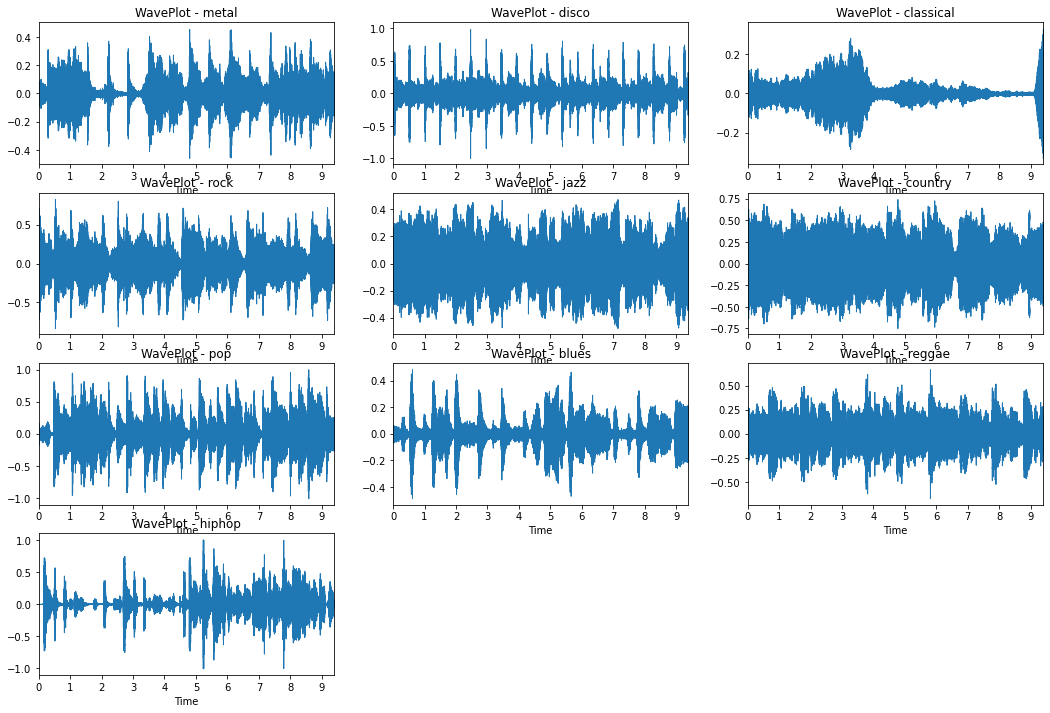

In [21]:
fig = plt.figure(figsize=(18, 12))

for i in range(train_samples.shape[0]):
    
  plt.subplot(4, 3, i + 1)

  librosa.display.waveplot(train_samples[i].squeeze(), sr=3000)

  plt.title(f"WavePlot - {idx_to_genres[i]}")
  # plt.tight_layout()
  
plt.show()

## Model Structure

### VQ

In [ ]:
test_latent_dim = 2
# the latent/embedding width needs to be shared between a.encoder output b. vq output and c. decoder input;
# should be treated as $$model width
test_VQ = VectorQuantizer(num_embeddings=6, embedding_dim=test_latent_dim)
print(test_VQ.get_usage_count())
test_VQ_out, test_latent_idx= test_VQ(tf.random.normal([32, 100, test_latent_dim]))
print(test_VQ.metrics[0].result())

tf.Tensor([0. 0. 0. 0. 0. 0.], shape=(6,), dtype=float32)
tf.Tensor(0.0, shape=(), dtype=float32)


In [ ]:
test_VQ_out.shape # [NTC]
test_VQ.embeddings.shape # (C, K)
print(test_latent_idx.shape) # (N, )
print(test_VQ.N_t)

(6,)
tf.Tensor([0. 0. 0. 0. 0. 0.], shape=(6,), dtype=float32)


In [ ]:
# tf.cast(tf.random.uniform([32, ]) >= 1, dtype=tf.int32)

#### Compute Usage count of all codebook vectors

<tf.Variable 'embeddings_vqvae:0' shape=(2, 6) dtype=float32, numpy=
array([[ 0.03454795,  0.02473347, -0.04470789,  0.03360689, -0.04464103,
        -0.00364071],
       [-0.0223442 , -0.04273237, -0.02664085, -0.04552197,  0.01086705,
         0.0101612 ]], dtype=float32)>
tf.Tensor(
[[ 0.  1.]
 [ 2.  3.]
 [ 4.  5.]
 [ 6.  7.]
 [ 8.  9.]
 [10. 11.]], shape=(6, 2), dtype=float32)
tf.Tensor([5 5 5 0 0 0], shape=(6,), dtype=int64)
N(t):  tf.Tensor([3. 0. 0. 0. 0. 3.], shape=(6,), dtype=float32)
tf.Tensor(2.0, shape=(), dtype=float32)


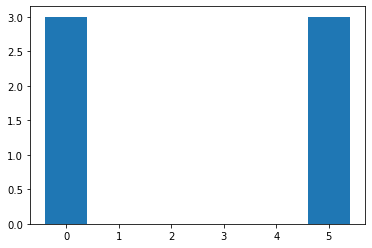

In [ ]:
a = tf.reshape(tf.range(0, 12, dtype=tf.float32), [6,2])
print(test_VQ.embeddings) # Embeddings 
print(a)
test_VQ_out, test_latent_idx= test_VQ(a)
# print(test_VQ_out)
print(test_latent_idx)
print("N(t): ", test_VQ.get_usage_count())
# plt.hist(test_VQ.N_t, bins=np.arange(len(test_VQ.N_t)))
plt.bar(x=np.arange(len(test_VQ.N_t)), height=test_VQ.N_t)
print(test_VQ.metrics[0].result())

In [ ]:
## Weights
# test_VQ.get_weights()
test_VQ.trainable_variables
## DEV PLT
# plt.bar(x=np.arange(len(test_VQ.N_t)), height=test_VQ.N_t)

[<tf.Variable 'embeddings_vqvae:0' shape=(2, 6) dtype=float32, numpy=
 array([[-0.04514531,  0.03053708, -0.01574315,  0.03144318,  0.04901738,
         -0.04233735],
        [-0.02782234, -0.03672327,  0.01434184,  0.00056743, -0.03729235,
          0.02454226]], dtype=float32)>]

#### Dialated Residual Block

In [ ]:
def residual_stack(input, filters, dialation_factor=3, depth=3, reverse_dilation=False):
    """Convolutional residual stack with weight normalization.

       Dilated Conv: A dilated convolution effectively allows the network to operate on 
                     a coarser scale than with a normal convolution. This is similar to pooling or strided convolutions, but
                     here the $$output has the same size as the input$$.
    Args:
        filter: int, determines filter size for the residual stack. output_embed_width
        dilation_factor: dilation grow rate
        reverse_dilation: TODO
        depth: TODO, being 3 for now

    Returns:
        Residual stack output.
    """
    
    # Depth of Residual block
    a1 = layers.ReLU()(input)
    # dilated Conv
    dr =dialation_factor ** 0 if not reverse_dilation else dialation_factor ** 2
    # d1 = layers.Conv1D(filters, 3, dilation_rate=dialation_factor ** 0 if not reverse_dilation else dialation_factor ** 2, padding="same", name=)(a1)
    d1 = layers.Conv1D(filters, 3, dilation_rate=dr, padding="same", name="dilation_cov1d_dr-{}".format(dr))(a1)
    a2 = layers.ReLU()(d1)
    c1 = layers.Conv1D(filters, 3, dilation_rate=1, padding="same")(a2)
    # residual connection
    r1 = layers.Add()([c1, input])

    a3 = layers.ReLU()(r1)
    # dilated Conv
    ## `strides > 1` not supported in conjunction with `dilation_rate > 1`. Received: strides=[2] and dilation_rate=[3]|
    dr = dilation_rate=dialation_factor ** 1
    d2 = layers.Conv1D(filters, 3, dilation_rate=dr,  padding="same", name="dilation_cov1d_dr-{}".format(dr))(a3)
    a4 = layers.ReLU()(d2)
    c2 = layers.Conv1D(filters, 3, dilation_rate=1, padding="same")(a4)
    # residual connection
    r2 = layers.Add()([c2, r1])

    a5 = layers.ReLU()(r2)
    # dilated Conv
    dr = dialation_factor ** 2 if not reverse_dilation else dialation_factor ** 0
    d3 = layers.Conv1D(filters, 3, dilation_rate=dr, padding="same", name="dilation_cov1d_dr-{}".format(dr))(a5)
    a6 = layers.ReLU()(d3)
    c3 = layers.Conv1D(filters, 3, dilation_rate=1, padding="same")(a6)
    # residual connection
    r3 = layers.Add()([c3, r2])


    return r3

In [ ]:
test_in_shape = (128, 4) # (T, C)
test_fiters = 4 # out_channel size, needs to be same as input filters size for residual connection
test_in = keras.Input(test_in_shape)
test_out = residual_stack(test_in, test_fiters, reverse_dilation=True)
test_model = keras.Model(test_in, test_out)

test_model.summary()

In [ ]:
print(test_model.layers[2])

In [ ]:
# reverse
test_sample = tf.random.normal([32, 128, 4])
test_res_out = residual_stack(test_sample, test_fiters)
test_res_out.shape # dilation conv won't change input shape

TensorShape([32, 128, 4])

### Encoder

In [ ]:
def create_encoder(input_shape, embed_width=64, output_embed_width=64):
    inp = keras.Input(input_shape)
    # x = MelSpec()(inp) // TODO, pre-processing?
    ## For each EncoderResidualConv block
    ## multiple down-sampling layers
    # # 1. down-sampling
    # x = layers.Conv1D(embed_width, 4, strides=2, padding="same")(inp)
    # # 2. Dilated Residual stack
    # # res_stack1 = residual_stack(x, embed_width)
    # res_stack1 = resnet.DilatedResnet1D(embed_width, 3, dilation_factor=3)(x)

    # # 3. Proj CONV with kernel==3
    # out1 = layers.Conv1D(output_embed_width, 3, strides=1, padding="same")(res_stack1)

    x = inp
    # Stack of Encoder Conv Block(s)
    for i in range(5): # hop_length being 2^5 == 32
      x = layers.Conv1D(embed_width, 4, strides=2, padding="same")(x)
      # deotg veubg 4
      x = resnet.DilatedResnet1D(embed_width, 4, dilation_factor=3)(x)

      # # make sure the down-sampling is working to reduce the sequence length
      # emb, T = embed_width, input_shape[-2] // (2 ** (i+1))
      # assert_shape(x, tf.TensorShape([None, emb, T]))

    conv_block_out = layers.Conv1D(output_embed_width, 3, strides=1, padding="same")(x)

    return keras.Model(inp, conv_block_out)

In [ ]:
test_encoder = create_encoder(test_in_shape)
test_encoder.summary()

In [ ]:
# DEV
model = tf.keras.Sequential()
model.add(tf.keras.layers.Dense(8, input_shape=(16,4)))
# Afterwards, we do automatic shape inference:
model.add(tf.keras.layers.Dense(4))
model.add(layers.Conv1D(32, 3))

In [ ]:
test_encoder.output.shape

TensorShape([None, 4, 64])

### Decoder
decoder mirrors the same structure of encoder while doing up-sampling (Conv1D Transpose)

In [ ]:
'''
  Args:
  @embed_width: $normally the channel dimension shared across encoder_output, codebook quantized dim and decoder input dim (for gradient pass-through)
  @residual_block_width: TODO
'''
def create_decoder(input_shape, embed_width=64, output_embed_width=1):
    inp = keras.Input(input_shape)

    ## For each DecoderResidualConv block
    # # 0. pre-process projection layer
    # x = layers.Conv1D(embed_width, 3, strides=1, padding="same")(inp)
    # ### Multiple for each up-sampling layer
    # # 1. Dilated Residual stack
    # # res_stack1 = residual_stack(x, embed_width, reverse_dilation=True)# dilation reverted (27 -> 9 -> 3 -> 1)
    # res_stack1 = resnet.DilatedResnet1D(embed_width, 3, dilation_factor=3, reverse_dilation=True)(x)
    # # 2. up-sampling
    # ## TODO: for the last layer, need to map to the input_embed_width if residual_block_widt != embed_width
    # out1 = layers.Conv1DTranspose(embed_width, 4, strides=2, padding="same")(res_stack1) # output of first up-sampling layer

    ## Stack of Decoder Conv Block(s)
    x = inp

    # Stack of Encoder Conv Block(s)
    ## pre-process projection layer
    x = layers.Conv1D(embed_width, 3, strides=1, padding="same")(x)
    for i in range(5):
      x = resnet.DilatedResnet1D(embed_width, 4, dilation_factor=3, reverse_dilation=True)(x)
      # up-sampling
      x = layers.Conv1DTranspose(embed_width, 4, strides=2, padding="same")(x)
   


    # The final Conv1D projects to the desired number of audio channels
    proj = layers.Conv1D(output_embed_width, 3, strides=1, padding='same')(x)

    return keras.Model(inp, proj)

In [ ]:
test_dec_in_shape = (100, 64) # (T, D)
test_decoder = create_decoder(test_dec_in_shape, embed_width=64)
test_decoder.summary()

In [ ]:
random_input = tf.random.normal([32, 256, 1]) # [NTC]
random_input.shape

TensorShape([32, 256, 1])

In [ ]:
## encoder -> decoder E2E
# test_enc_out = test_encoder(random_input)

## VQ-VAE

In [ ]:
'''
 Encoder -> Decoder E2E
 Hop-Length: 2^5 == 32

 TODO: move it to its own class for hierarchical structure

 Args:
 @latent_dim: model_width
'''
def get_vqvae(input_shape, latent_dim, depth, down_depth, strides, num_embeddings=128, residual_width=64, residual_depth=4, dilation_factor=1):
    # VQ
    vq_layer = VectorQuantizer(num_embeddings, latent_dim, name="vector_quantizer")

    # Encoder
    # encoder = create_encoder(input_shape, embed_width=latent_dim)
    encoder = encdec.Encoder(output_dim=latent_dim, residual_width=residual_width, residual_depth=residual_depth, 
                             depth=depth, down_depth=down_depth, strides=strides, dilation_factor=dilation_factor)
    # dec_in_shape = encoder.output.shape[1:]
    # print("Decoder Input/Encoder Output Shape: {}".format(dec_in_shape))

    # Decoder
    # decoder = create_decoder(dec_in_shape, embed_width=latent_dim, output_embed_width=input_shape[-1]) # reconstruction shape should align with input channel width
    decoder = encdec.Decoder(output_dim=input_shape[-1], embed_width=latent_dim, residual_width=residual_width, residual_depth=residual_depth, 
                             depth=depth, down_depth=down_depth, strides=strides, dilation_factor=dilation_factor)
    
    inputs = keras.Input(shape=input_shape)
    encoder_outputs = encoder(inputs)
    quantized_latents= vq_layer(encoder_outputs)
    # print("VQ output:", quantized_latents)
    reconstructions = decoder(quantized_latents)
    # reconstructions = decoder(encoder_outputs)
    return keras.Model(inputs, reconstructions, name="vq_vae")

"""
 Single Level VQ-VAE
"""
def get_vqvae(input_shape, encoder, decoder, vq):
    inputs = keras.Input(shape=input_shape)
    encoder_outputs = encoder(inputs)
    quantized_latents, _= vq(encoder_outputs)
    # print("VQ output:", quantized_latents)
    reconstructions = decoder(quantized_latents)
    return keras.Model(inputs, reconstructions, name="vq_vae")

In [ ]:
random_input.shape

TensorShape([32, 256, 1])

In [ ]:
test_vqvae = get_vqvae(sample_batch.shape[1:], latent_dim=64, num_embeddings=512, depth=1, down_depth=[5], strides=[2])
test_vqvae.summary()

In [ ]:
test_vqvae_out = test_vqvae(sample_batch)
test_vqvae_out.shape

TensorShape([8, 28000, 1])

In [ ]:
test_vqvae = VQVAE(sample_batch.shape[1:], latent_dim=64, num_embeddings=512, depth=1, down_depth=[5], strides=[2], residual_width=64)
print(test_vqvae(sample_batch).shape)
test_vqvae.summary()

Adding EncoderConvBlock: 0
Adding DecoderConvBlock: 0
(8, 28000, 1)
Model: "vqvae_26"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vector_quantizer (VectorQua  multiple                 32768     
 ntizer)                                                         
                                                                 
 encoder_51 (Encoder)        multiple                  572544    
                                                                 
 decoder_50 (Decoder)        multiple                  588865    
                                                                 
Total params: 1,194,177
Trainable params: 1,194,177
Non-trainable params: 0
_________________________________________________________________


### Trainer

In [88]:
## Reload Module
# del vqvae
import vqvae
importlib.reload(resnet)
importlib.reload(encdec)
importlib.reload(VectorQuantizer)
importlib.reload(data_utils)
importlib.reload(vqvae)

<module 'vqvae' from 'C:\\Users\\Zeyu Sun\\Documents\\GitHub\\VAE-based-Music--Deep-Generative-Models\\vqvae.py'>

In [96]:
# vqvae_trainer = VQVAETrainer(sample_batch.shape[1:], latent_dim=64, num_embeddings=512, depth=1, down_depth=[5], strides=[2]) # codebook size
# vqvae_trainer.compile(optimizer=keras.optimizers.Adam()) #, run_eagerly=True) # eager mode for debug...
## Load From Module
# vqvae_trainer = vqvae.VQVAE(sample_batch.shape[1:], levels=1, latent_dim=64, num_embeddings=512, down_depth=[8], strides=[2], dilation_factor=3, residual_width=32) #  Debug when NT < K
vqvae_trainer = vqvae.VQVAE(sample_batch.shape[1:], levels=2, latent_dim=64, num_embeddings=512, down_depth=[5, 3], strides=[2, 2], dilation_factor=3, residual_width=32) # codebook size
# vqvae_trainer = vqvae.VQVAE(sample_batch.shape[1:], levels=1, latent_dim=64, num_embeddings=512, down_depth=[5], strides=[2], dilation_factor=3)
# vqvae_trainer.compile(optimizer=keras.optimizers.Adam()) #, run_eagerly=True) # eager mode for debug...

Adding EncoderConvBlock: 0
Adding EncoderConvBlock: 0
Adding EncoderConvBlock: 1
Adding DecoderConvBlock: 0
Adding DecoderConvBlock: 1
Adding DecoderConvBlock: 0


In [97]:
# vqvae_trainer.vqvae(sample_batch)
# vqvae_trainer.vqvae.summary()
for vqvae_ in vqvae_trainer.vqvaes:
  vqvae_.summary()

Model: "vq_vae_0"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_9 (InputLayer)        [(None, 28160, 1)]        0         
                                                                 
 encoder_0 (Encoder)         (None, 880, 64)           147040    
                                                                 
 vector_quantizer_0 (VectorQ  ((None, 880, 64),        66048     
 uantizer)                    (None,))                           
                                                                 
 decoder_0 (Decoder)         (None, 28160, 1)          155297    
                                                                 
Total params: 368,385
Trainable params: 302,337
Non-trainable params: 66,048
_________________________________________________________________
Model: "vq_vae_1"
_________________________________________________________________
 Layer (type)                

In [98]:
# encdec.print_dec_layer(vqvae_trainer.decoder) # Check Dilation pattern

In [99]:
print(vqvae_trainer.metrics)
# print(vqvae_trainer.vq.metrics)
for vq in vqvae_trainer.vqs:
  for m in vq.metrics:
    print(m.name) 
d = {m.name : m.result() for m in vqvae_trainer.vqs[0].metrics}
d

[<keras.metrics.Mean object at 0x0000011C8EBFEEB0>, <keras.metrics.Mean object at 0x0000011C8FB14280>, <keras.metrics.Mean object at 0x0000011C8E6A50D0>, <keras.metrics.Mean object at 0x0000011C902D2400>, <keras.metrics.Mean object at 0x0000011C902D2AC0>, <keras.metrics.Mean object at 0x0000011C902D2940>, <keras.metrics.Mean object at 0x0000011C902E49A0>, <keras.metrics.Mean object at 0x0000011C902E4700>, <keras.metrics.Mean object at 0x0000011C902EE730>, <keras.metrics.Mean object at 0x0000011C902EE490>, <keras.metrics.Mean object at 0x0000011C902F64C0>, <keras.metrics.Mean object at 0x0000011C902F6220>]
[0]batch_codebook_usage
[0]codebook_usage
[0]codebook_entropy
[1]batch_codebook_usage
[1]codebook_usage
[1]codebook_entropy


{'[0]batch_codebook_usage': <tf.Tensor: shape=(), dtype=float32, numpy=0.0>,
 '[0]codebook_usage': <tf.Tensor: shape=(), dtype=float32, numpy=0.0>,
 '[0]codebook_entropy': <tf.Tensor: shape=(), dtype=float32, numpy=0.0>}

In [100]:
dict(hhh=1.0, rere=2.0)

{'hhh': 1.0, 'rere': 2.0}

In [109]:
#DEV VQ
# vqvae_trainer.get_quantizer().N_t
# print(vqvae_trainer.get_quantizer().embeddings)
# print(vqvae_trainer.get_quantizer().get_usage_count())
print(vqvae_trainer.vqs[0].trainable_variables)
# print(vqvae_trainer.vq.get_weights())
# for w, var in zip(vqvae_trainer.vq.get_weights(), vqvae_trainer.vq.variables):
#     print("Variable: "+var.name)
#     print(w.shape)
#     print(w)
# print(vqvae_trainer.vqvaes[0].trainable_variables)

[]


In [114]:
print(sum([np.prod(var.numpy().shape) for var in vqvae_trainer.vqvaes[0].trainable_variables]))

302337


##### Validation

In [115]:
#### Validation between Epoches TODO: move to module
'''
 sample latent z based on actual test data x
'''
def generate_and_save_waves(model, epoch, test_sample, if_quantized=False, channel_last=False, print_codebook_distribution=False):

  ## Codebook Vector usage (Put ahead reconstruction, given that vq preserve the last N_t for now)
  if print_codebook_distribution:
    vq_usage = model.get_quantizer().get_usage_count()
    print("Snapshot of Codebook Vector usage, Size(K/D, ): {}; SUM (last Batch size x latent_len){} ".format(tf.shape(vq_usage), tf.math.reduce_sum(vq_usage)))
    fig = plt.figure(figsize=(10, 5))
    plt.title("VQ Codebook Vector Usage Count")
    # plt.hist(vq_usage.numpy()) # should use bar...
    plt.bar(x=np.arange(len(vq_usage)), height=vq_usage.numpy())
    plt.show()

  print("[DEBUG] TOTAL Number of Trainable Weights for model: {}".format(sum([np.prod(var.numpy().shape) for var in model.trainable_variables])))

  # Direct Reconstruction (x -> x')
  input = test_sample
  if channel_last:
    input = np.transpose(test_sample, [0,2,1])
  predictions = model(input).numpy()
  print("Reconstructed Output: ", predictions.shape)
  fig = plt.figure(figsize=(18, 12))
  ret = []

  if if_quantized: # mu-law transformation
    # recover int waveform to float waveform
    # Greedy Sampling
    predictions = np.argmax(predictions, axis=-1)
    print("Sampled quantized: ", predictions.shape, predictions[0])

    predictions = mu_law_decode(predictions, QUANTIZATION_CHANNELS)

    print("Max: {}, Min: {}".format(np.amax(predictions), np.amin(predictions)))

  for i in range(predictions.shape[0]):
    waves = predictions[i]
    plt.subplot(4, 3, i + 1)

    if i==9:
      print("X': ", waves.squeeze())
      print(f"X range: [{np.amax(waves)}, {np.amin(waves)}]")

    librosa.display.waveplot(waves.squeeze(), sr=SAMPLE_RATE)
    plt.title(f"WavePlot - {idx_to_genres[i]}")
    # plt.tight_layout()
    ret.append(predictions[i])
    
  plt.show()


  return ret

In [103]:
1e-4

0.0001

In [104]:
# Callbacks
class VAEMonitor(tf.keras.callbacks.Callback):
    """A callback to generate and save images after each epoch"""

    def __init__(self, **kwargs):
        super(VAEMonitor, self).__init__(**kwargs)

    def on_epoch_end(self, epoch, logs=None):
      ## DEBUG
      for level in range(self.model.levels):
        print("\n-------------------------Epoch: {}, Level: {}------------------------------".format(epoch, level))
        vq = self.model.vqs[level]
        codebook_usage = tf.reduce_sum(tf.cast(vq.get_usage_count() >= 1.0, dtype=tf.float32))
        collapsed_code = tf.reduce_sum(tf.cast(vq.get_usage_count() <= 0.0, dtype=tf.float32))
        print("\n[VQ DEBUG] Snap shot of N_t: {}; Code<=0... {}".format(codebook_usage, collapsed_code))
        # Reset the metrics!!!
        print("\nResetting the metrics...")
        for m in self.model.vqvaes[level].metrics:
          m.reset_state()
        for m in self.model.vqs[level].metrics:
          m.reset_state()

      # Periodic Inspect
      if epoch % 5 == 0:
        print("\n[DEBUG] This is Callback Monitor: End of Epoch", epoch)
        print("---------------------------Running Validation DataSet---------------------------")
        self.model.evaluate(test_dataset)
        for level in range(self.model.levels):
          print("-------------------------------ReConstruction of Training Samples for Level: {}-------------------------------".format(level))
          generate_and_save_waves(self.model.vqvaes[level], epoch, train_samples)
        # generate_and_save_waves(self.model, epoch, train_samples, if_quantized=True, channel_last=True)

vae_monitor = VAEMonitor()

In [105]:
15e-5

0.00015

Epoch 1/100
113/113 [==============================] - ETA: 0s - loss: 2.7073 - recon_loss: 0.0605 - vqvae_loss: 0.0302 - spectral_loss: 2.1001 - [0]level_loss: 1.0972 - [0]recon_loss: 0.0241 - [0]vq_loss: 0.0018 - [0]spectral_loss: 1.0713 - [0]batch_codebook_usage: 68.0568 - [0]codebook_usage: 433.7432 - [0]codebook_entropy: 2.6561 - [1]level_loss: 1.0658 - [1]recon_loss: 0.0247 - [1]vq_loss: 0.0123 - [1]spectral_loss: 1.0288 - [1]batch_codebook_usage: 100.6173 - [1]codebook_usage: 291.5010 - [1]codebook_entropy: 3.4533
-------------------------Epoch: 0, Level: 0------------------------------

[VQ DEBUG] Snap shot of N_t: 502.0; Code<=0... 0.0

Resetting the metrics...

-------------------------Epoch: 0, Level: 1------------------------------

[VQ DEBUG] Snap shot of N_t: 379.0; Code<=0... 0.0

Resetting the metrics...

[DEBUG] This is Callback Monitor: End of Epoch 0
---------------------------Running Validation DataSet---------------------------
13/13 [==============================

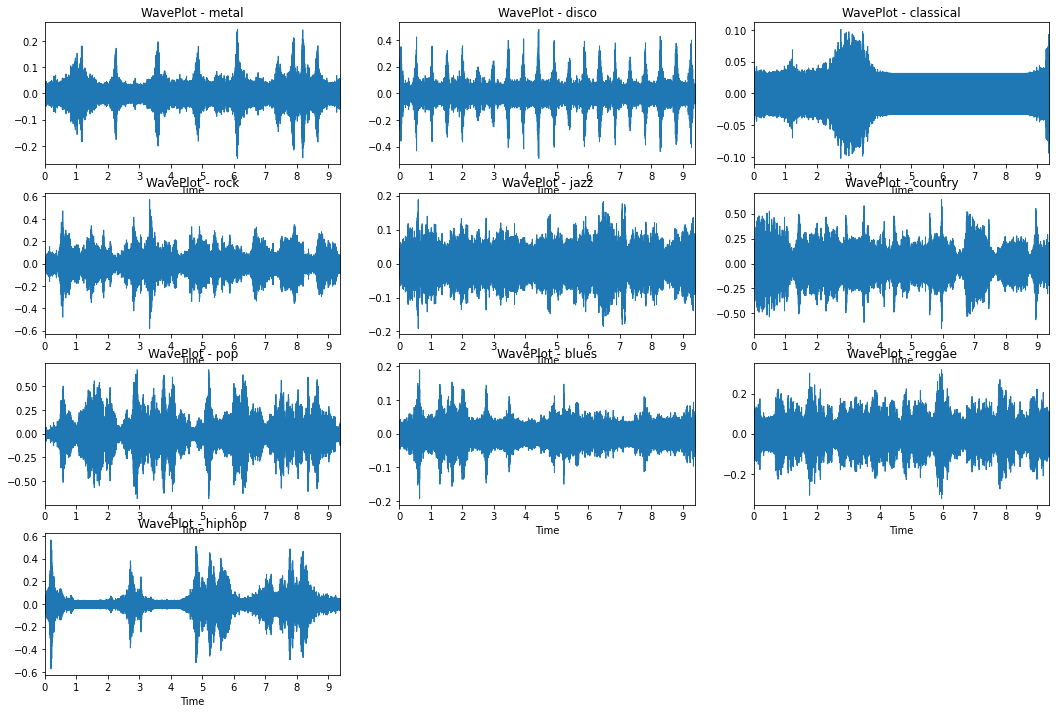

-------------------------------ReConstruction of Training Samples for Level: 1-------------------------------
Reconstructed Output:  (10, 28160, 1)
X':  [ 0.01292653 -0.00303947 -0.00388108 ... -0.01611836  0.02110728
  0.01596779]
X range: [0.2894631028175354, -0.34892377257347107]


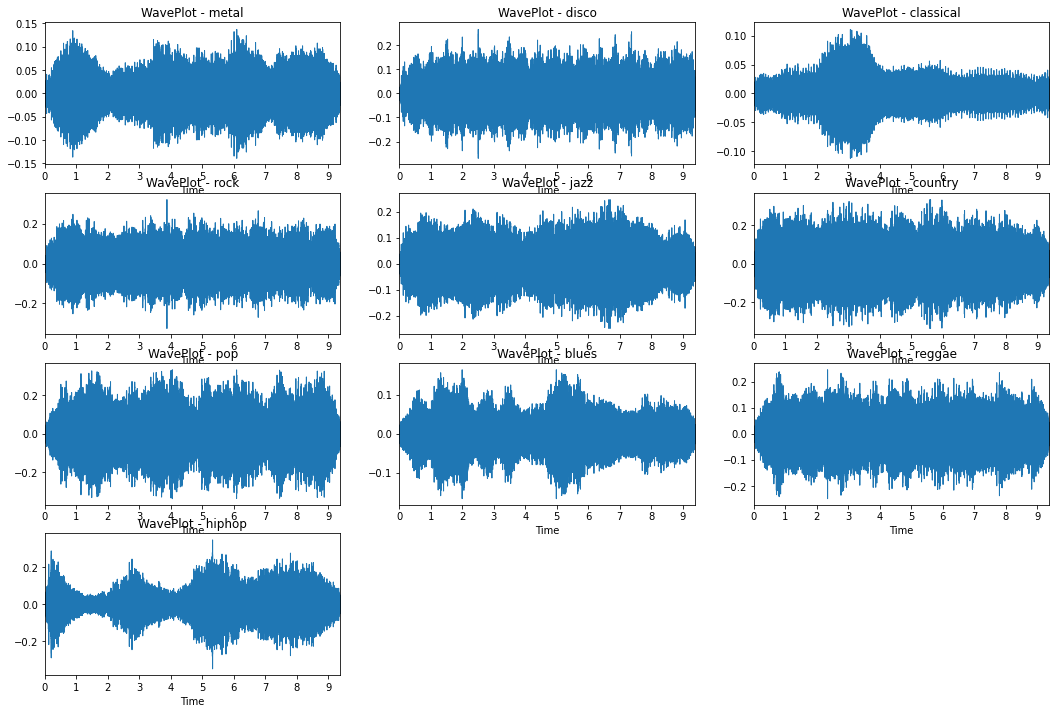

113/113 [==============================] - 56s 300ms/step - loss: 2.7025 - recon_loss: 0.0604 - vqvae_loss: 0.0300 - spectral_loss: 2.1001 - [0]level_loss: 1.0972 - [0]recon_loss: 0.0241 - [0]vq_loss: 0.0018 - [0]spectral_loss: 1.0713 - [0]batch_codebook_usage: 68.0595 - [0]codebook_usage: 434.1960 - [0]codebook_entropy: 2.6571 - [1]level_loss: 1.0658 - [1]recon_loss: 0.0247 - [1]vq_loss: 0.0123 - [1]spectral_loss: 1.0288 - [1]batch_codebook_usage: 100.6668 - [1]codebook_usage: 292.2789 - [1]codebook_entropy: 3.4551 - lr: 0.0010
Epoch 2/100
113/113 [==============================] - ETA: 0s - loss: 1.8015 - recon_loss: 0.0582 - vqvae_loss: 0.0152 - spectral_loss: 1.7048 - [0]level_loss: 0.8848 - [0]recon_loss: 0.0309 - [0]vq_loss: 0.0091 - [0]spectral_loss: 0.8448 - [0]batch_codebook_usage: 154.9088 - [0]codebook_usage: 505.7619 - [0]codebook_entropy: 3.8413 - [1]level_loss: 0.8936 - [1]recon_loss: 0.0254 - [1]vq_loss: 0.0081 - [1]spectral_loss: 0.8601 - [1]batch_codebook_usage: 196.90

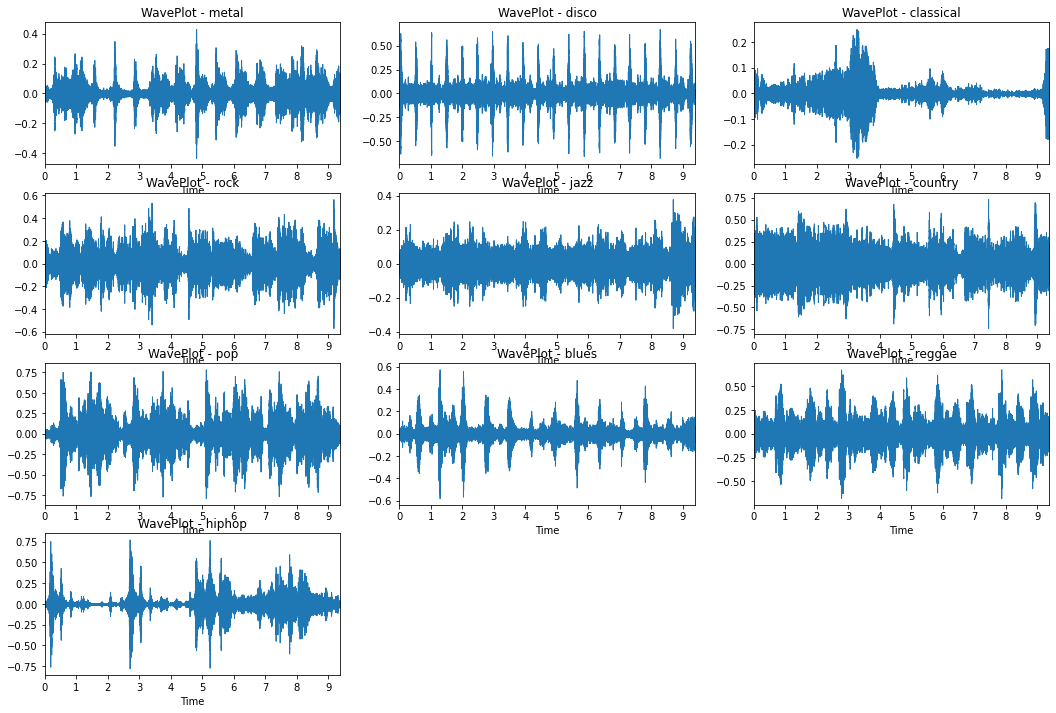

-------------------------------ReConstruction of Training Samples for Level: 1-------------------------------
Reconstructed Output:  (10, 28160, 1)
X':  [-0.01064518 -0.01680265 -0.01363512 ... -0.00779368  0.00246103
  0.00683999]
X range: [0.6021270751953125, -0.725651741027832]


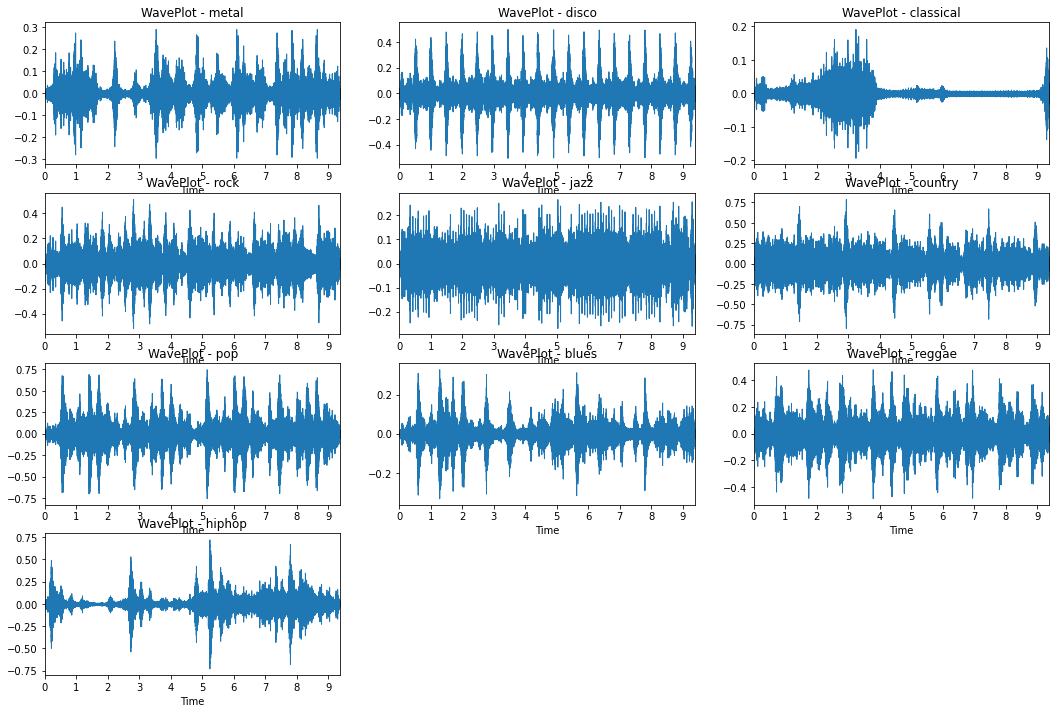

113/113 [==============================] - 28s 246ms/step - loss: 1.5758 - recon_loss: 0.0410 - vqvae_loss: 0.0663 - spectral_loss: 1.4621 - [0]level_loss: 0.7337 - [0]recon_loss: 0.0129 - [0]vq_loss: 0.0603 - [0]spectral_loss: 0.6605 - [0]batch_codebook_usage: 475.6485 - [0]codebook_usage: 511.3110 - [0]codebook_entropy: 5.7072 - [1]level_loss: 0.8332 - [1]recon_loss: 0.0272 - [1]vq_loss: 0.0044 - [1]spectral_loss: 0.8017 - [1]batch_codebook_usage: 251.2374 - [1]codebook_usage: 228.8593 - [1]codebook_entropy: 5.0311 - lr: 0.0010
Epoch 7/100
113/113 [==============================] - ETA: 0s - loss: 1.5417 - recon_loss: 0.0386 - vqvae_loss: 0.0644 - spectral_loss: 1.4344 - [0]level_loss: 0.7129 - [0]recon_loss: 0.0122 - [0]vq_loss: 0.0594 - [0]spectral_loss: 0.6413 - [0]batch_codebook_usage: 490.1081 - [0]codebook_usage: 511.4289 - [0]codebook_entropy: 5.7817 - [1]level_loss: 0.8248 - [1]recon_loss: 0.0272 - [1]vq_loss: 0.0046 - [1]spectral_loss: 0.7931 - [1]batch_codebook_usage: 245.3

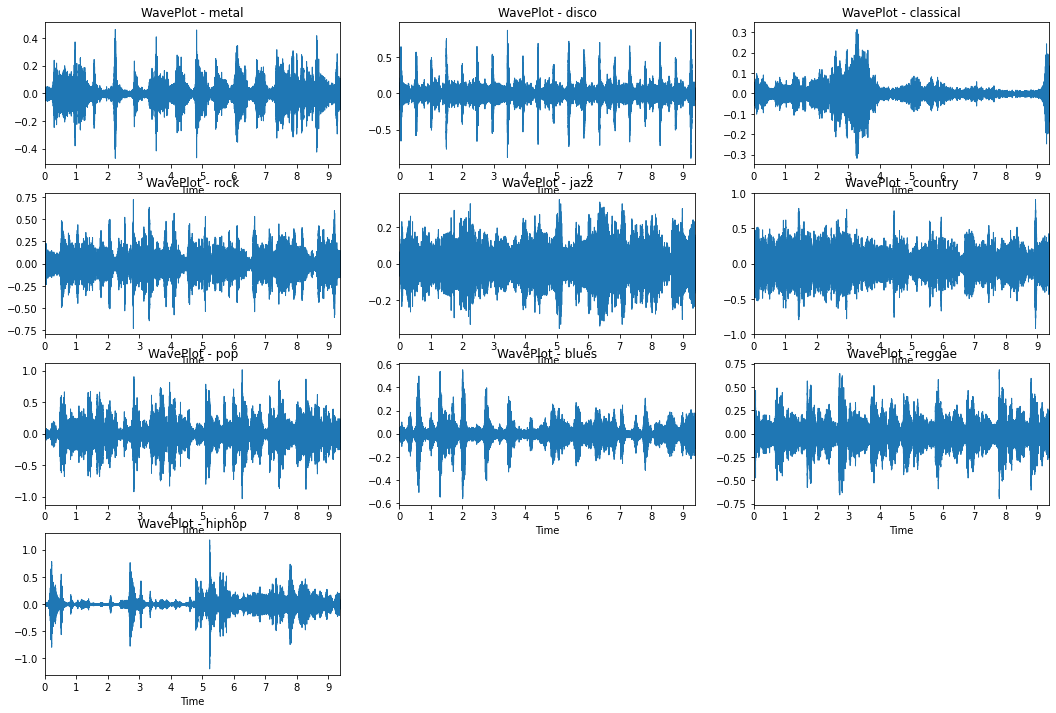

-------------------------------ReConstruction of Training Samples for Level: 1-------------------------------
Reconstructed Output:  (10, 28160, 1)
X':  [ 0.0076183  -0.00656096 -0.00186922 ...  0.0028512   0.00130613
  0.00036081]
X range: [0.6185528635978699, -0.7389079928398132]


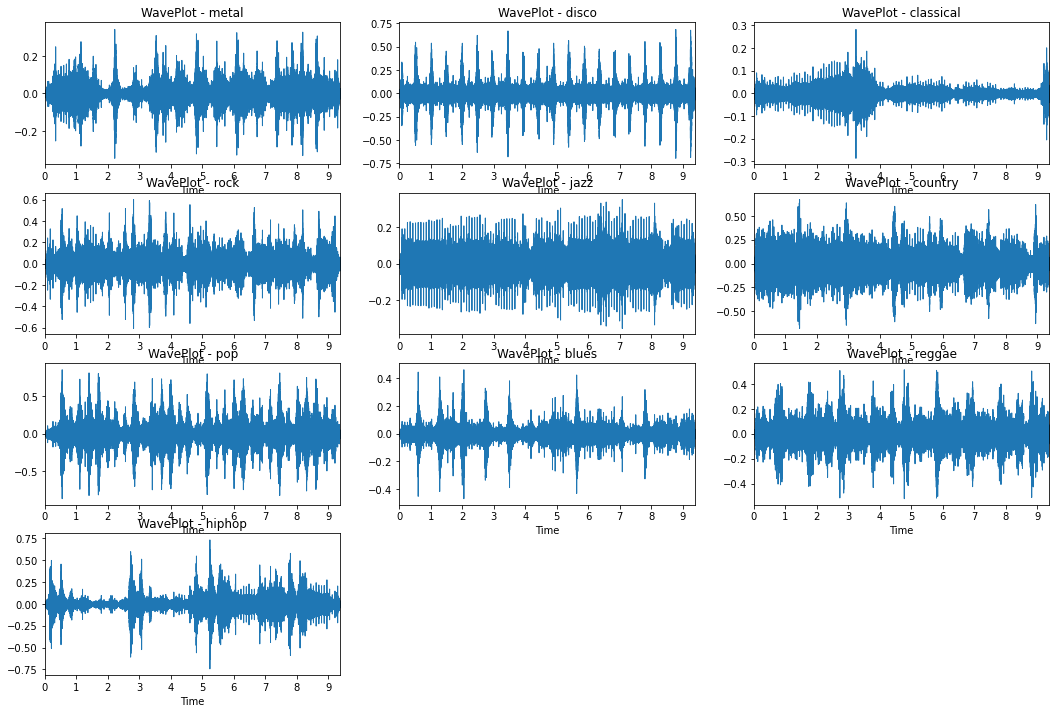

113/113 [==============================] - 28s 246ms/step - loss: 1.4830 - recon_loss: 0.0388 - vqvae_loss: 0.0635 - spectral_loss: 1.3910 - [0]level_loss: 0.6827 - [0]recon_loss: 0.0110 - [0]vq_loss: 0.0584 - [0]spectral_loss: 0.6133 - [0]batch_codebook_usage: 503.8300 - [0]codebook_usage: 512.0000 - [0]codebook_entropy: 5.9185 - [1]level_loss: 0.8115 - [1]recon_loss: 0.0279 - [1]vq_loss: 0.0060 - [1]spectral_loss: 0.7777 - [1]batch_codebook_usage: 249.3181 - [1]codebook_usage: 218.8170 - [1]codebook_entropy: 5.0754 - lr: 0.0010
Epoch 12/100
113/113 [==============================] - ETA: 0s - loss: 1.4856 - recon_loss: 0.0397 - vqvae_loss: 0.0601 - spectral_loss: 1.3892 - [0]level_loss: 0.6803 - [0]recon_loss: 0.0107 - [0]vq_loss: 0.0569 - [0]spectral_loss: 0.6128 - [0]batch_codebook_usage: 498.5703 - [0]codebook_usage: 512.0000 - [0]codebook_entropy: 5.9045 - [1]level_loss: 0.8098 - [1]recon_loss: 0.0278 - [1]vq_loss: 0.0056 - [1]spectral_loss: 0.7764 - [1]batch_codebook_usage: 251.

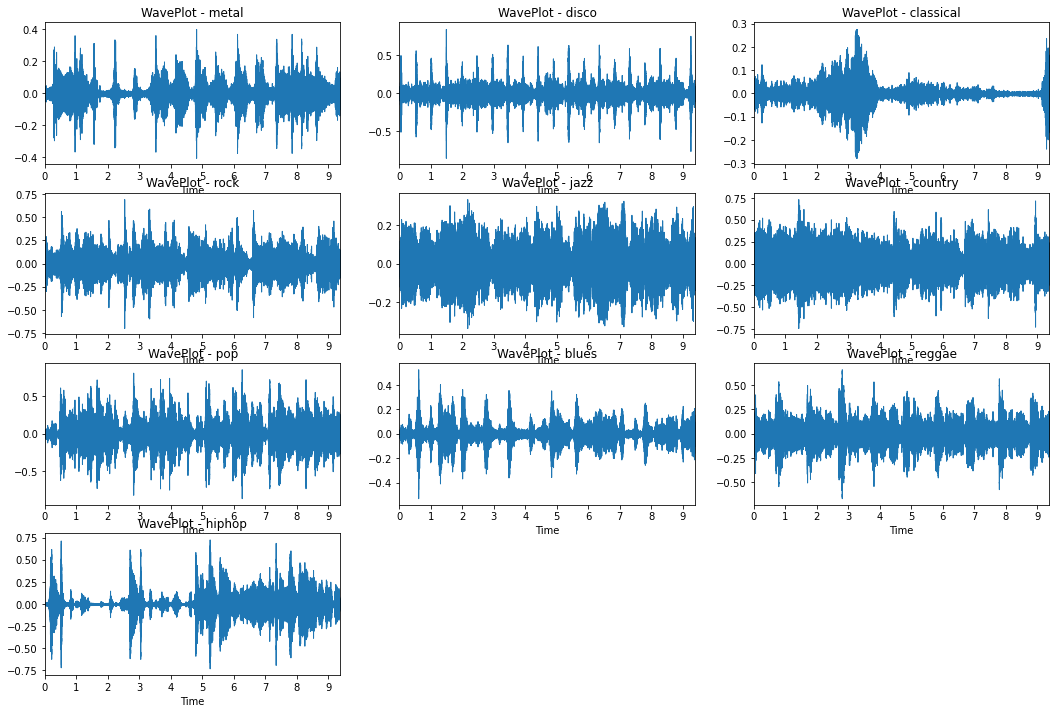

-------------------------------ReConstruction of Training Samples for Level: 1-------------------------------
Reconstructed Output:  (10, 28160, 1)
X':  [-0.00211353 -0.00612642 -0.01032532 ... -0.00764628 -0.00178855
 -0.00114198]
X range: [0.570937991142273, -0.7370842099189758]


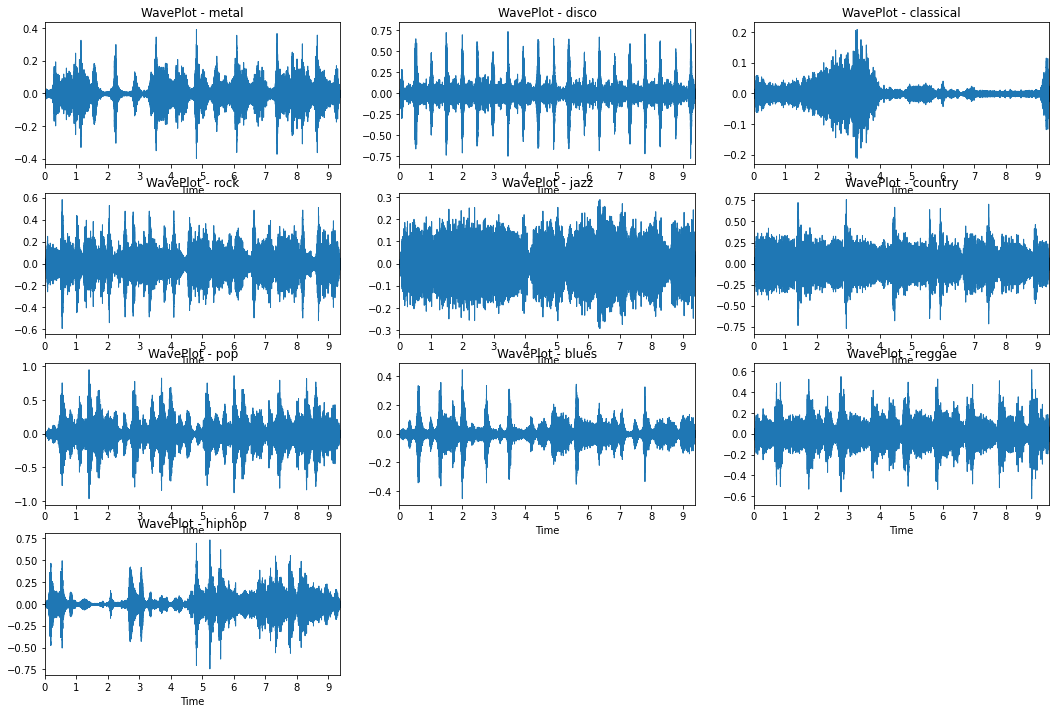

113/113 [==============================] - 28s 249ms/step - loss: 1.4673 - recon_loss: 0.0375 - vqvae_loss: 0.0748 - spectral_loss: 1.3368 - [0]level_loss: 0.6527 - [0]recon_loss: 0.0099 - [0]vq_loss: 0.0709 - [0]spectral_loss: 0.5719 - [0]batch_codebook_usage: 502.5610 - [0]codebook_usage: 512.0000 - [0]codebook_entropy: 5.9351 - [1]level_loss: 0.7995 - [1]recon_loss: 0.0281 - [1]vq_loss: 0.0065 - [1]spectral_loss: 0.7649 - [1]batch_codebook_usage: 258.3880 - [1]codebook_usage: 221.1697 - [1]codebook_entropy: 5.0818 - lr: 0.0010
Epoch 17/100
113/113 [==============================] - ETA: 0s - loss: 1.4430 - recon_loss: 0.0401 - vqvae_loss: 0.0785 - spectral_loss: 1.3263 - [0]level_loss: 0.6464 - [0]recon_loss: 0.0097 - [0]vq_loss: 0.0733 - [0]spectral_loss: 0.5634 - [0]batch_codebook_usage: 502.2172 - [0]codebook_usage: 512.0000 - [0]codebook_entropy: 5.9355 - [1]level_loss: 0.7978 - [1]recon_loss: 0.0281 - [1]vq_loss: 0.0068 - [1]spectral_loss: 0.7629 - [1]batch_codebook_usage: 259.

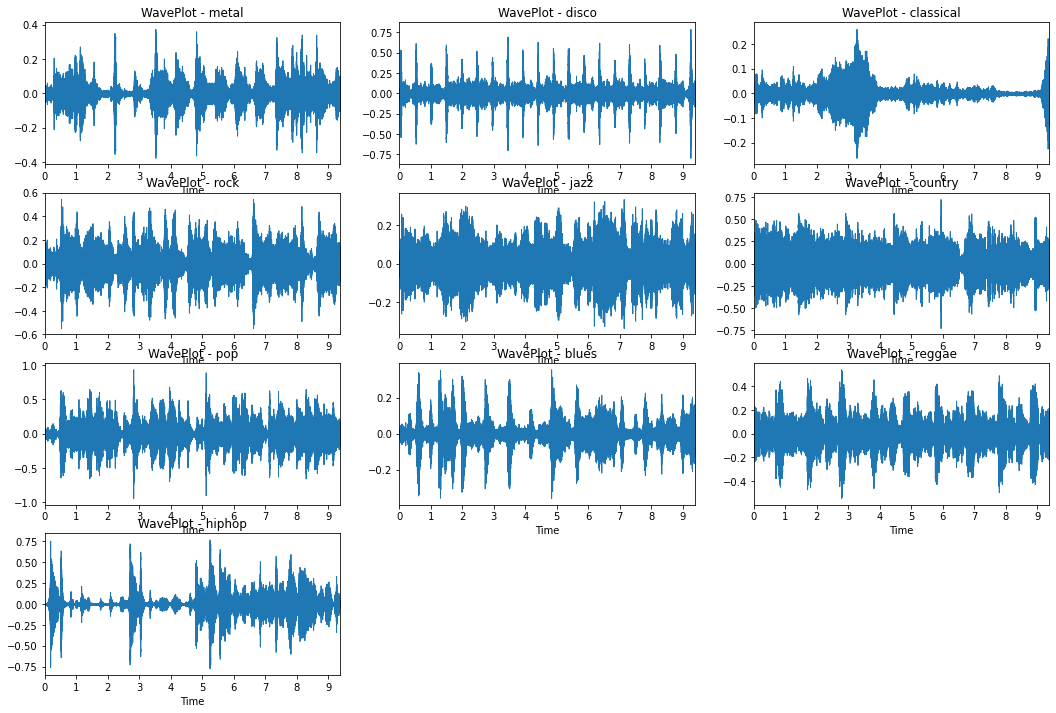

-------------------------------ReConstruction of Training Samples for Level: 1-------------------------------
Reconstructed Output:  (10, 28160, 1)
X':  [-0.00961995  0.00273225 -0.00189576 ... -0.00101456  0.00420936
  0.01017758]
X range: [0.6527149081230164, -0.6100988388061523]


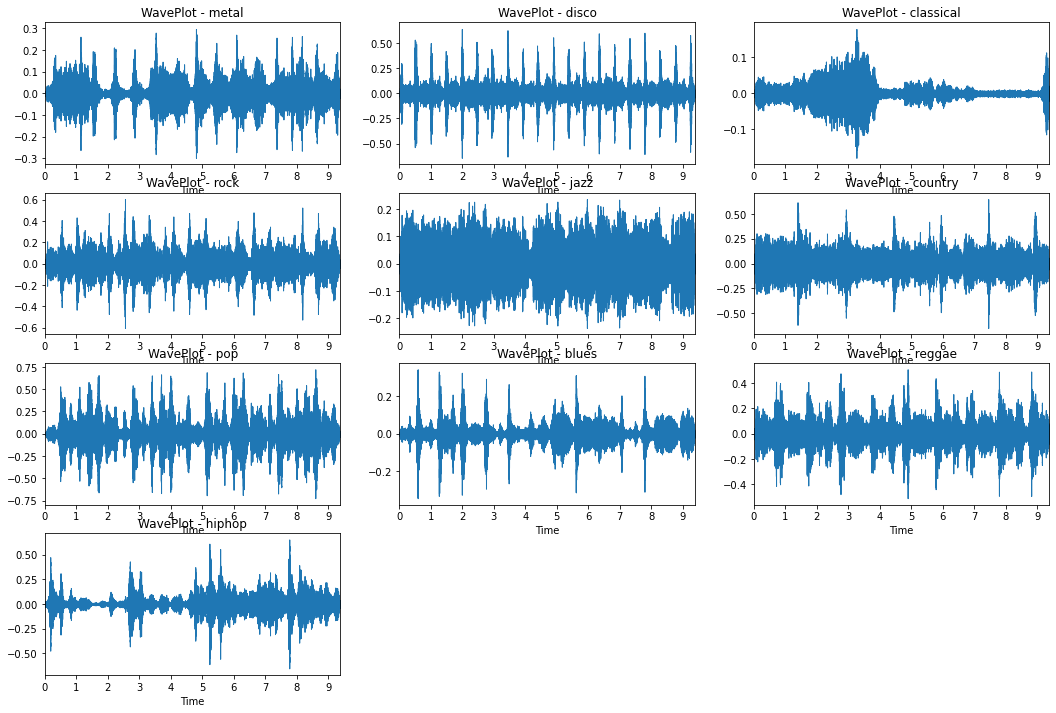

113/113 [==============================] - 28s 247ms/step - loss: 1.4381 - recon_loss: 0.0394 - vqvae_loss: 0.0883 - spectral_loss: 1.3141 - [0]level_loss: 0.6357 - [0]recon_loss: 0.0093 - [0]vq_loss: 0.0779 - [0]spectral_loss: 0.5485 - [0]batch_codebook_usage: 501.7977 - [0]codebook_usage: 512.0000 - [0]codebook_entropy: 5.9459 - [1]level_loss: 0.8014 - [1]recon_loss: 0.0282 - [1]vq_loss: 0.0076 - [1]spectral_loss: 0.7656 - [1]batch_codebook_usage: 273.2554 - [1]codebook_usage: 210.9349 - [1]codebook_entropy: 5.1743 - lr: 0.0010
Epoch 22/100
113/113 [==============================] - ETA: 0s - loss: 1.4211 - recon_loss: 0.0370 - vqvae_loss: 0.0854 - spectral_loss: 1.2968 - [0]level_loss: 0.6326 - [0]recon_loss: 0.0092 - [0]vq_loss: 0.0790 - [0]spectral_loss: 0.5445 - [0]batch_codebook_usage: 499.5592 - [0]codebook_usage: 512.0000 - [0]codebook_entropy: 5.9295 - [1]level_loss: 0.7889 - [1]recon_loss: 0.0283 - [1]vq_loss: 0.0082 - [1]spectral_loss: 0.7524 - [1]batch_codebook_usage: 267.

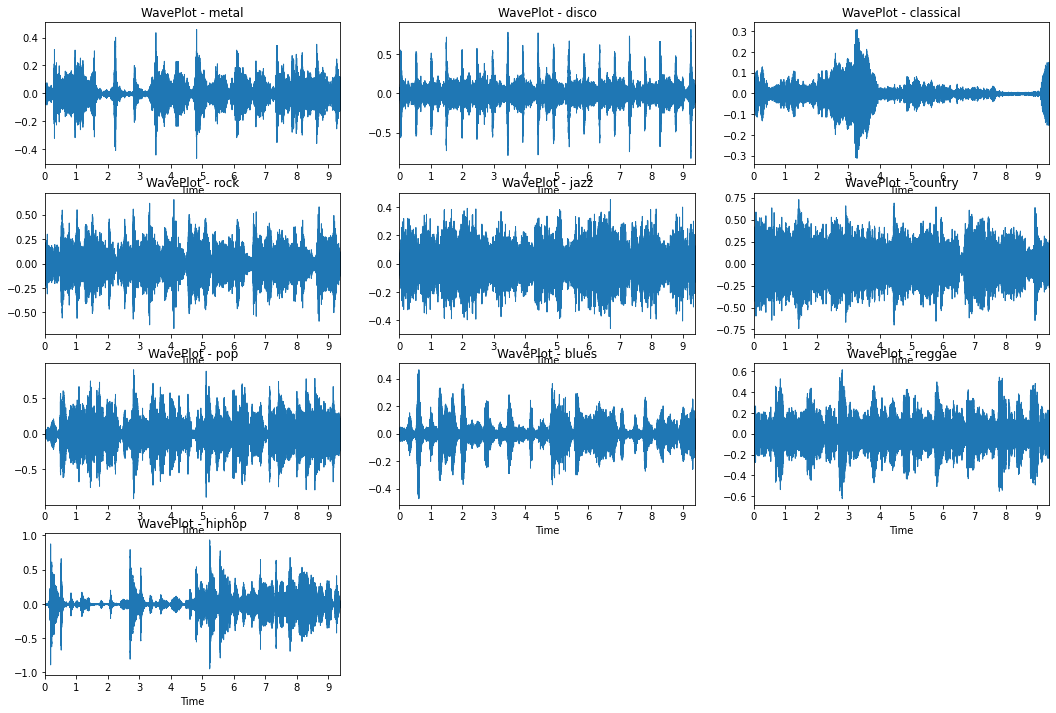

-------------------------------ReConstruction of Training Samples for Level: 1-------------------------------
Reconstructed Output:  (10, 28160, 1)
X':  [-1.3649811e-03  1.4515889e-03 -5.5798935e-03 ... -2.3220989e-03
 -5.4310672e-03  6.7033936e-05]
X range: [0.6028022766113281, -0.6302353143692017]


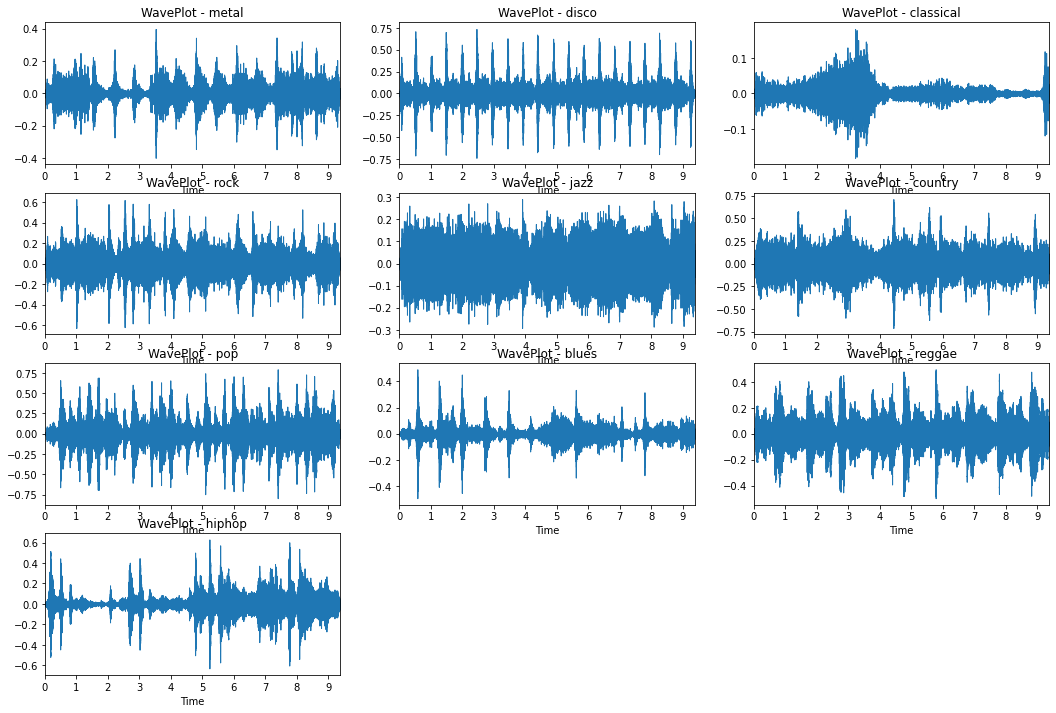

113/113 [==============================] - 29s 253ms/step - loss: 1.4159 - recon_loss: 0.0378 - vqvae_loss: 0.0959 - spectral_loss: 1.2819 - [0]level_loss: 0.6281 - [0]recon_loss: 0.0089 - [0]vq_loss: 0.0875 - [0]spectral_loss: 0.5318 - [0]batch_codebook_usage: 495.9159 - [0]codebook_usage: 512.0000 - [0]codebook_entropy: 5.8900 - [1]level_loss: 0.7893 - [1]recon_loss: 0.0285 - [1]vq_loss: 0.0107 - [1]spectral_loss: 0.7502 - [1]batch_codebook_usage: 273.0682 - [1]codebook_usage: 319.4035 - [1]codebook_entropy: 5.1500 - lr: 0.0010
Epoch 27/100
113/113 [==============================] - ETA: 0s - loss: 1.4111 - recon_loss: 0.0383 - vqvae_loss: 0.0971 - spectral_loss: 1.2754 - [0]level_loss: 0.6250 - [0]recon_loss: 0.0088 - [0]vq_loss: 0.0886 - [0]spectral_loss: 0.5276 - [0]batch_codebook_usage: 496.0191 - [0]codebook_usage: 512.0000 - [0]codebook_entropy: 5.8984 - [1]level_loss: 0.7861 - [1]recon_loss: 0.0284 - [1]vq_loss: 0.0099 - [1]spectral_loss: 0.7477 - [1]batch_codebook_usage: 278.

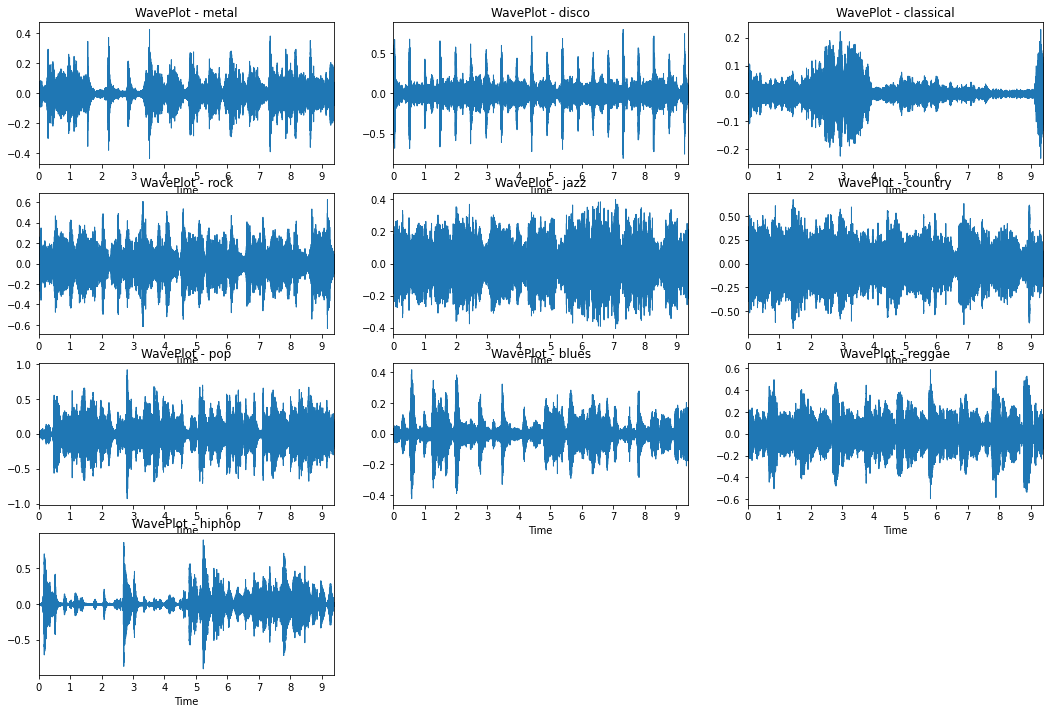

-------------------------------ReConstruction of Training Samples for Level: 1-------------------------------
Reconstructed Output:  (10, 28160, 1)
X':  [ 0.00229901 -0.00183561 -0.00089437 ... -0.00559695 -0.00778542
 -0.01069608]
X range: [0.6703554391860962, -0.6427561640739441]


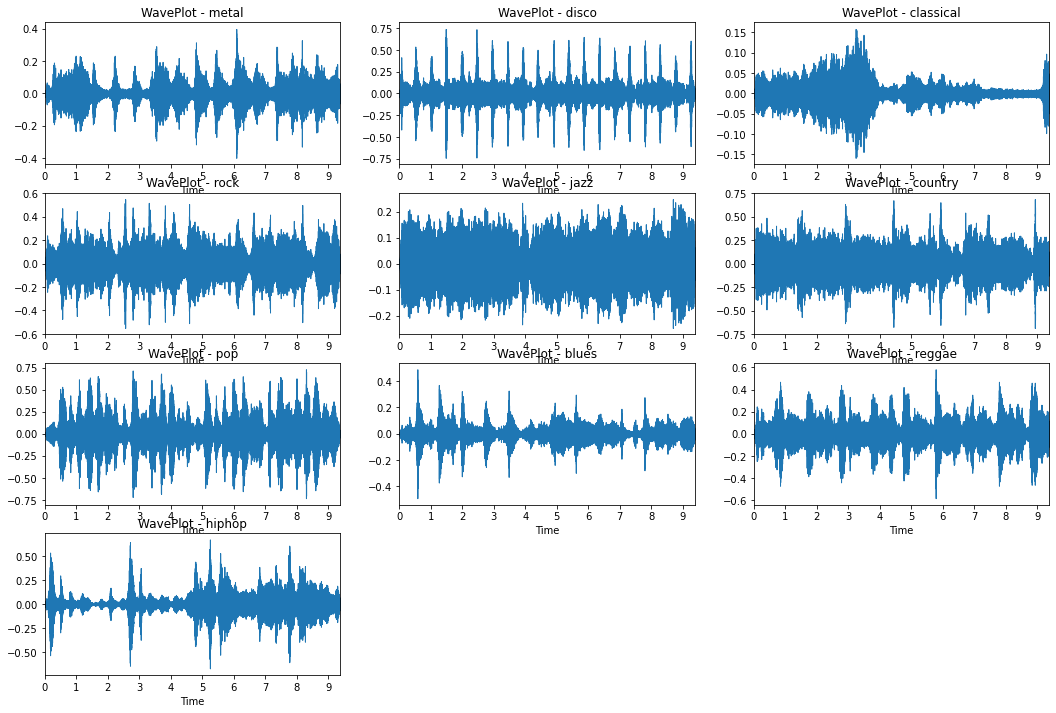

113/113 [==============================] - 28s 251ms/step - loss: 1.3883 - recon_loss: 0.0363 - vqvae_loss: 0.0998 - spectral_loss: 1.2545 - [0]level_loss: 0.6246 - [0]recon_loss: 0.0089 - [0]vq_loss: 0.0905 - [0]spectral_loss: 0.5252 - [0]batch_codebook_usage: 493.1421 - [0]codebook_usage: 512.0000 - [0]codebook_entropy: 5.8589 - [1]level_loss: 0.7681 - [1]recon_loss: 0.0291 - [1]vq_loss: 0.0097 - [1]spectral_loss: 0.7292 - [1]batch_codebook_usage: 286.0456 - [1]codebook_usage: 263.2200 - [1]codebook_entropy: 5.2582 - lr: 0.0010
Epoch 32/100
113/113 [==============================] - ETA: 0s - loss: 1.3822 - recon_loss: 0.0375 - vqvae_loss: 0.0973 - spectral_loss: 1.2475 - [0]level_loss: 0.6203 - [0]recon_loss: 0.0087 - [0]vq_loss: 0.0917 - [0]spectral_loss: 0.5199 - [0]batch_codebook_usage: 489.0319 - [0]codebook_usage: 512.0000 - [0]codebook_entropy: 5.8348 - [1]level_loss: 0.7659 - [1]recon_loss: 0.0289 - [1]vq_loss: 0.0094 - [1]spectral_loss: 0.7276 - [1]batch_codebook_usage: 286.

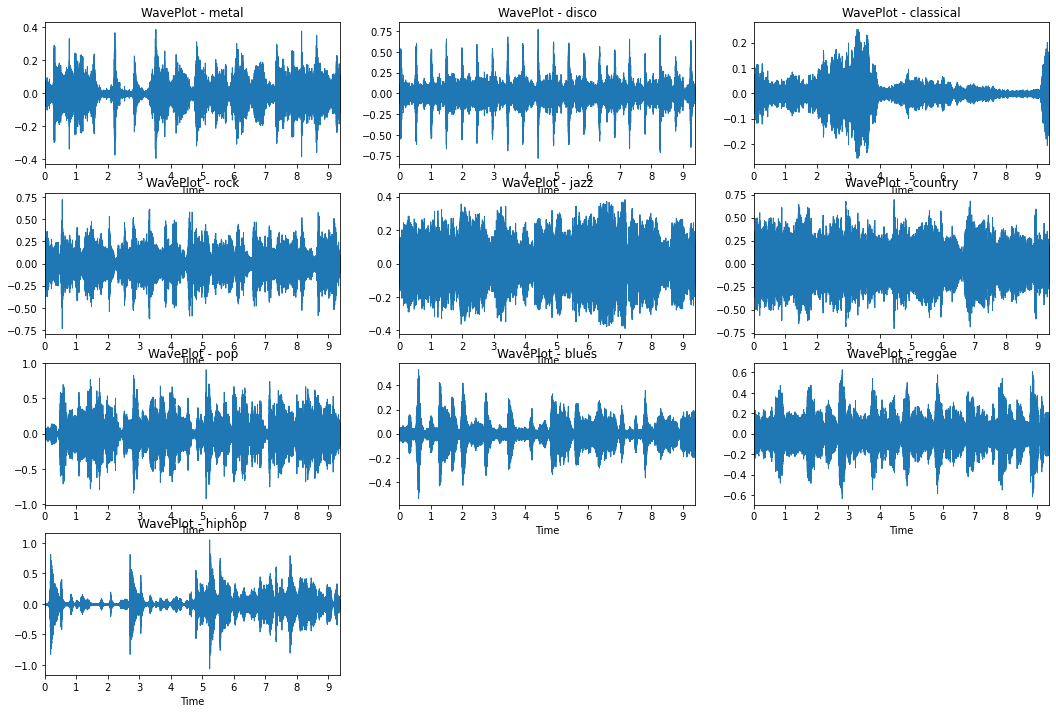

-------------------------------ReConstruction of Training Samples for Level: 1-------------------------------
Reconstructed Output:  (10, 28160, 1)
X':  [ 0.00273712 -0.00533097 -0.0068207  ... -0.00207434 -0.00360634
 -0.005093  ]
X range: [0.6167849898338318, -0.7589505314826965]


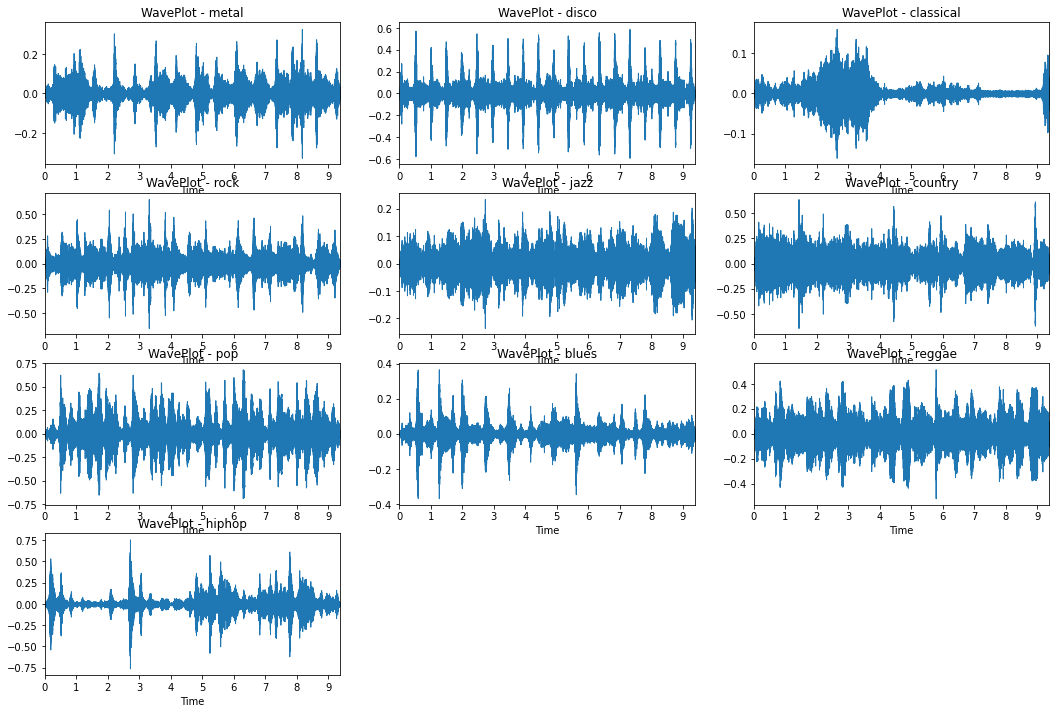

113/113 [==============================] - 28s 244ms/step - loss: 1.3856 - recon_loss: 0.0374 - vqvae_loss: 0.1067 - spectral_loss: 1.2576 - [0]level_loss: 0.6196 - [0]recon_loss: 0.0086 - [0]vq_loss: 0.0982 - [0]spectral_loss: 0.5128 - [0]batch_codebook_usage: 489.7067 - [0]codebook_usage: 512.0000 - [0]codebook_entropy: 5.8186 - [1]level_loss: 0.7835 - [1]recon_loss: 0.0285 - [1]vq_loss: 0.0103 - [1]spectral_loss: 0.7448 - [1]batch_codebook_usage: 287.4974 - [1]codebook_usage: 278.3222 - [1]codebook_entropy: 5.2609 - lr: 0.0010
Epoch 37/100
113/113 [==============================] - ETA: 0s - loss: 1.4232 - recon_loss: 0.0353 - vqvae_loss: 0.1049 - spectral_loss: 1.2615 - [0]level_loss: 0.6302 - [0]recon_loss: 0.0089 - [0]vq_loss: 0.0951 - [0]spectral_loss: 0.5262 - [0]batch_codebook_usage: 487.2885 - [0]codebook_usage: 512.0000 - [0]codebook_entropy: 5.8162 - [1]level_loss: 0.7754 - [1]recon_loss: 0.0287 - [1]vq_loss: 0.0113 - [1]spectral_loss: 0.7354 - [1]batch_codebook_usage: 292.

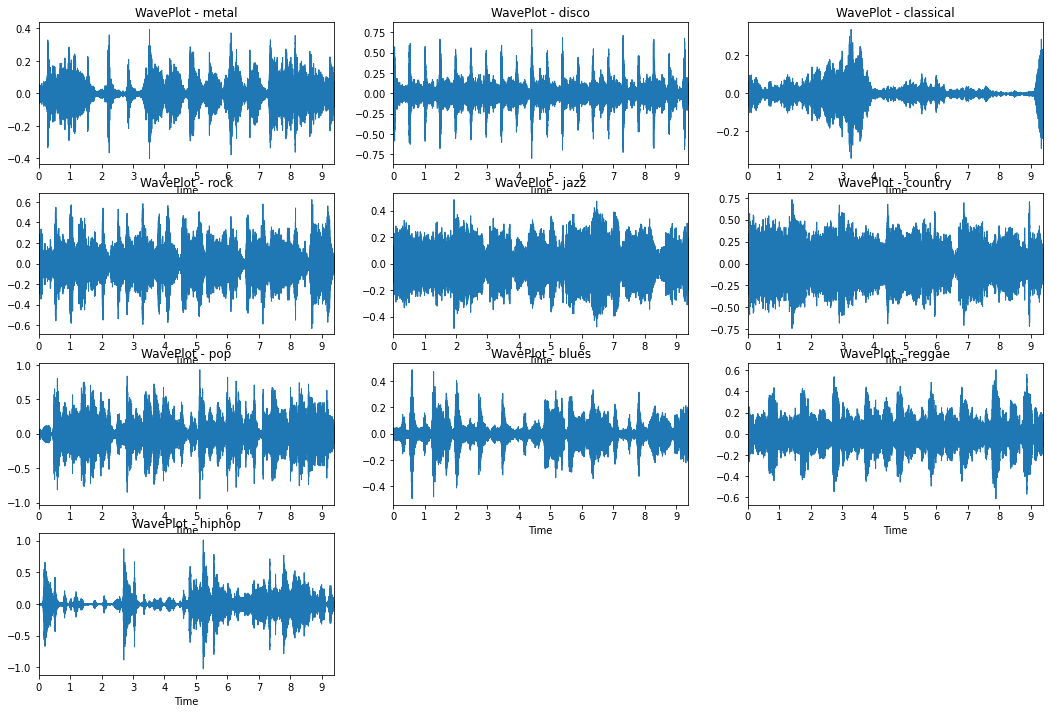

-------------------------------ReConstruction of Training Samples for Level: 1-------------------------------
Reconstructed Output:  (10, 28160, 1)
X':  [-2.8167376e-02 -2.4694804e-02 -1.9450556e-02 ...  2.6576221e-05
 -1.2963871e-04  2.7351119e-03]
X range: [0.6750170588493347, -0.6988190412521362]


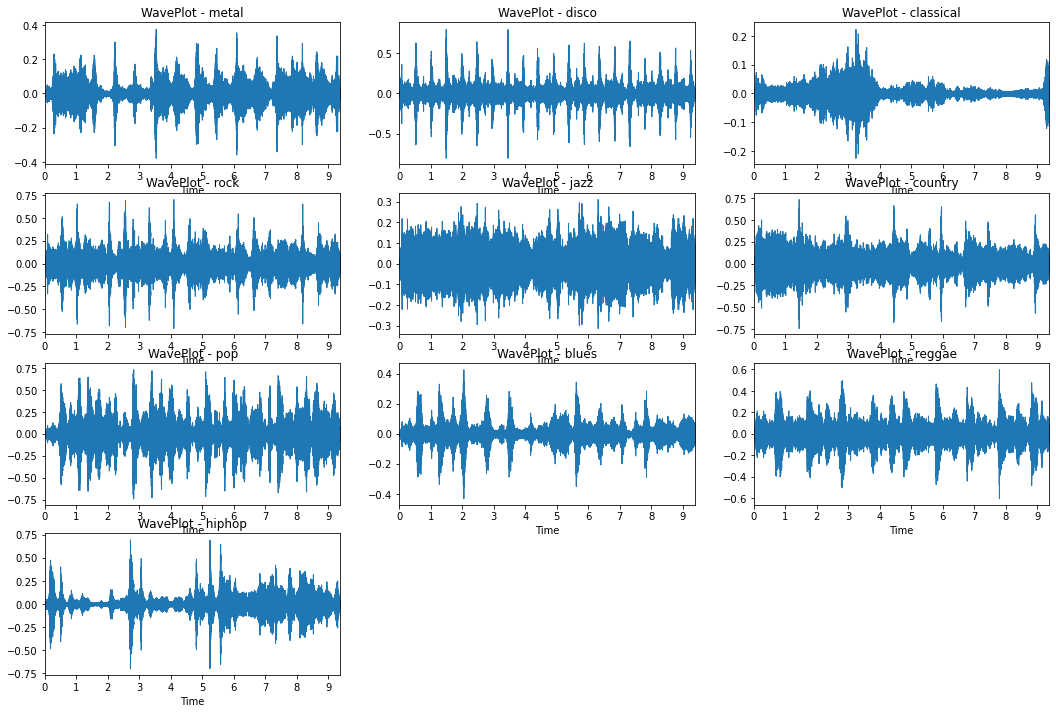

113/113 [==============================] - 28s 244ms/step - loss: 1.3654 - recon_loss: 0.0390 - vqvae_loss: 0.1124 - spectral_loss: 1.2167 - [0]level_loss: 0.6155 - [0]recon_loss: 0.0085 - [0]vq_loss: 0.1043 - [0]spectral_loss: 0.5027 - [0]batch_codebook_usage: 489.1986 - [0]codebook_usage: 512.0000 - [0]codebook_entropy: 5.8030 - [1]level_loss: 0.7536 - [1]recon_loss: 0.0292 - [1]vq_loss: 0.0104 - [1]spectral_loss: 0.7140 - [1]batch_codebook_usage: 300.8778 - [1]codebook_usage: 286.4081 - [1]codebook_entropy: 5.3485 - lr: 0.0010
Epoch 42/100
113/113 [==============================] - ETA: 0s - loss: 1.3635 - recon_loss: 0.0389 - vqvae_loss: 0.1178 - spectral_loss: 1.2133 - [0]level_loss: 0.6143 - [0]recon_loss: 0.0085 - [0]vq_loss: 0.1062 - [0]spectral_loss: 0.4996 - [0]batch_codebook_usage: 490.2216 - [0]codebook_usage: 512.0000 - [0]codebook_entropy: 5.8327 - [1]level_loss: 0.7546 - [1]recon_loss: 0.0293 - [1]vq_loss: 0.0116 - [1]spectral_loss: 0.7137 - [1]batch_codebook_usage: 305.

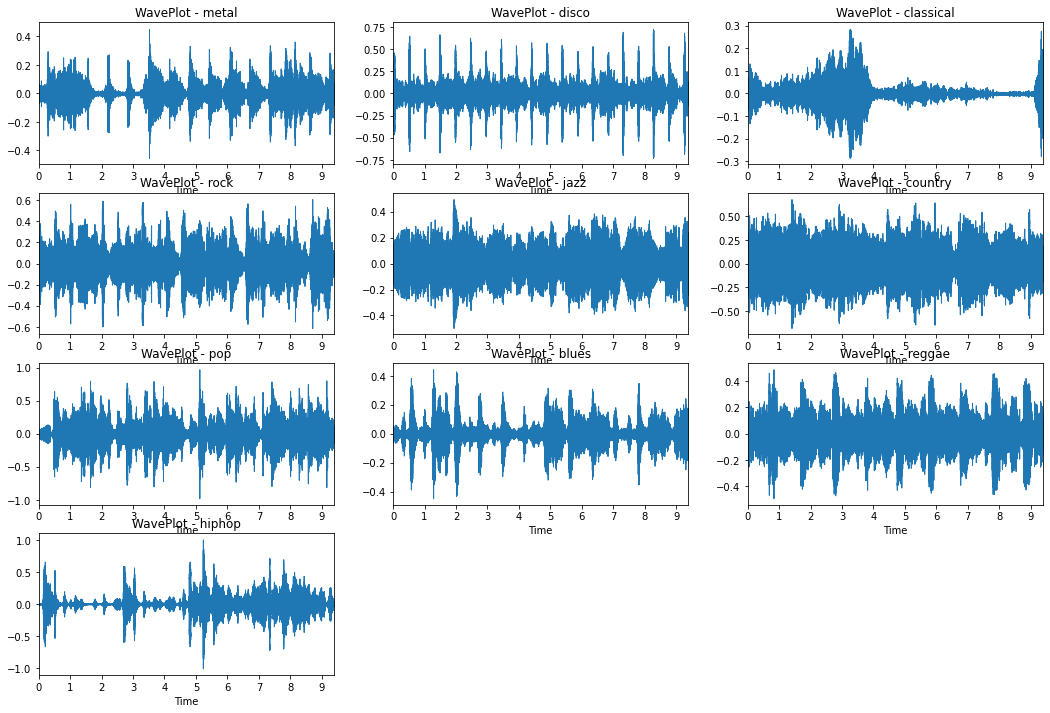

-------------------------------ReConstruction of Training Samples for Level: 1-------------------------------
Reconstructed Output:  (10, 28160, 1)
X':  [-0.01014669 -0.01672516 -0.013235   ...  0.00237451 -0.00394949
 -0.00417863]
X range: [0.5457171201705933, -0.5521864295005798]


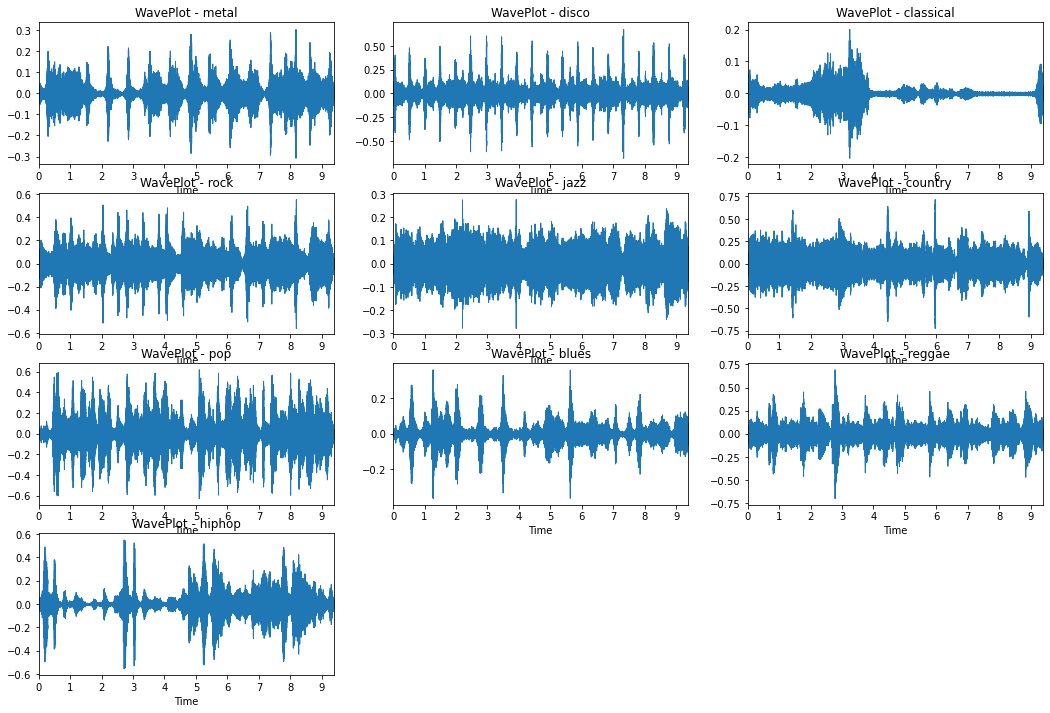

113/113 [==============================] - 27s 244ms/step - loss: 1.3662 - recon_loss: 0.0374 - vqvae_loss: 0.1208 - spectral_loss: 1.2134 - [0]level_loss: 0.6170 - [0]recon_loss: 0.0085 - [0]vq_loss: 0.1047 - [0]spectral_loss: 0.5038 - [0]batch_codebook_usage: 487.7224 - [0]codebook_usage: 512.0000 - [0]codebook_entropy: 5.7872 - [1]level_loss: 0.7503 - [1]recon_loss: 0.0291 - [1]vq_loss: 0.0116 - [1]spectral_loss: 0.7096 - [1]batch_codebook_usage: 305.1393 - [1]codebook_usage: 292.2579 - [1]codebook_entropy: 5.3822 - lr: 0.0010
Epoch 47/100
113/113 [==============================] - ETA: 0s - loss: 1.3718 - recon_loss: 0.0396 - vqvae_loss: 0.1167 - spectral_loss: 1.2042 - [0]level_loss: 0.6134 - [0]recon_loss: 0.0084 - [0]vq_loss: 0.1063 - [0]spectral_loss: 0.4987 - [0]batch_codebook_usage: 487.4472 - [0]codebook_usage: 512.0000 - [0]codebook_entropy: 5.7690 - [1]level_loss: 0.7462 - [1]recon_loss: 0.0290 - [1]vq_loss: 0.0117 - [1]spectral_loss: 0.7055 - [1]batch_codebook_usage: 305.

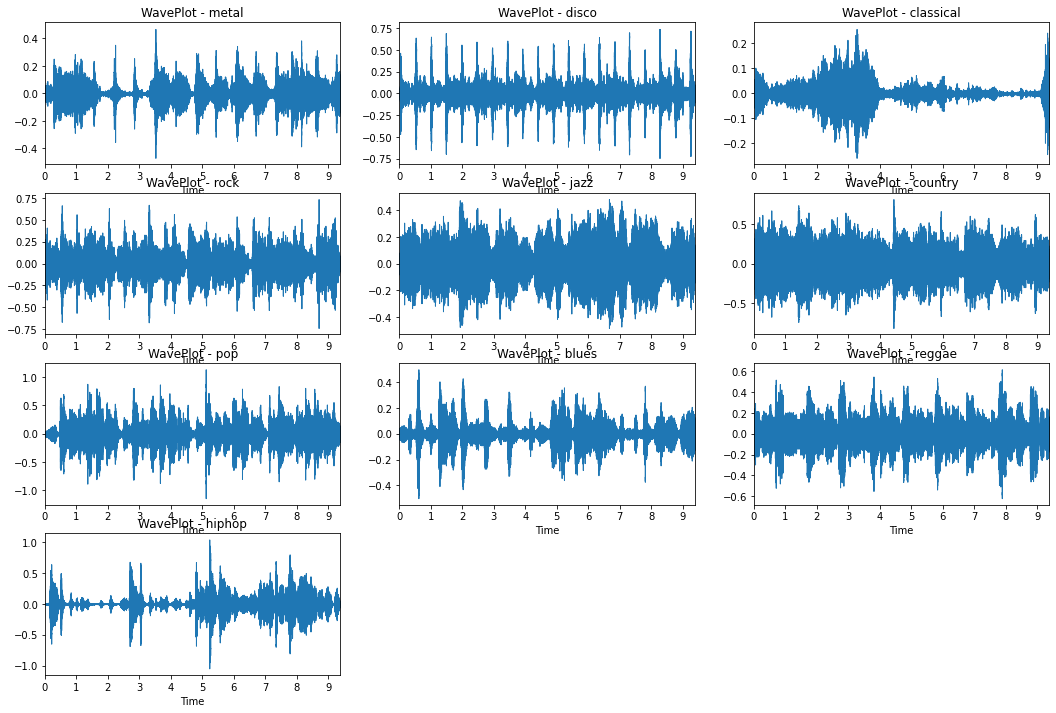

-------------------------------ReConstruction of Training Samples for Level: 1-------------------------------
Reconstructed Output:  (10, 28160, 1)
X':  [-0.00238977 -0.00909536 -0.00532    ...  0.00597028  0.00492139
 -0.00079165]
X range: [0.6180768013000488, -0.6149680018424988]


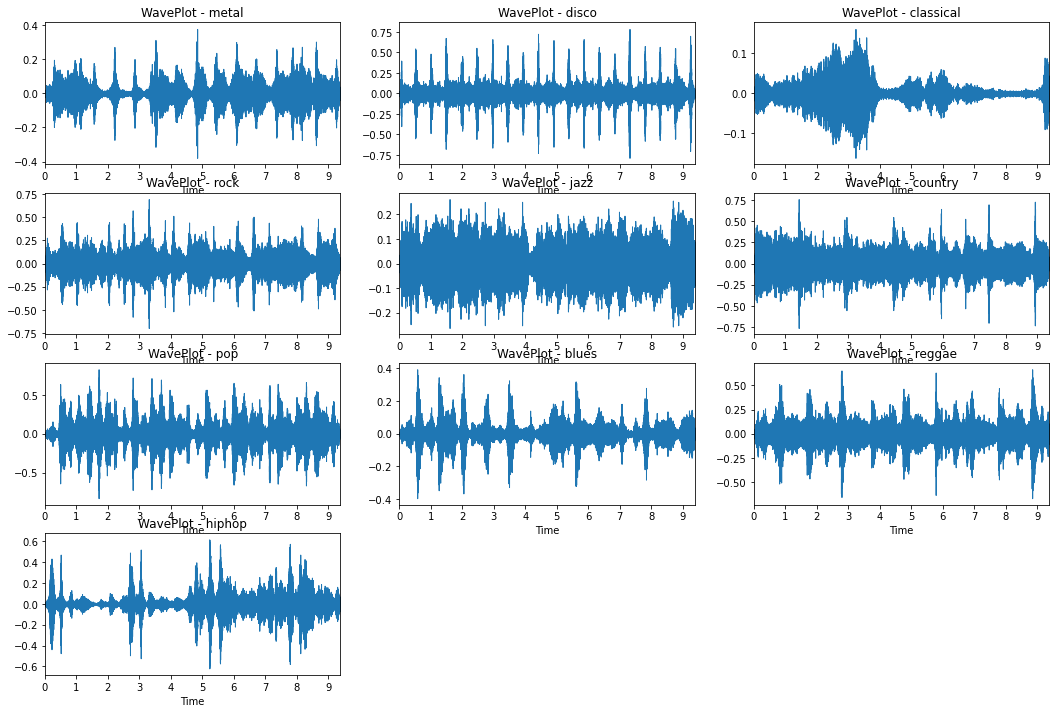


Epoch 00051: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
113/113 [==============================] - 29s 257ms/step - loss: 1.3549 - recon_loss: 0.0364 - vqvae_loss: 0.1226 - spectral_loss: 1.1958 - [0]level_loss: 0.6103 - [0]recon_loss: 0.0084 - [0]vq_loss: 0.1105 - [0]spectral_loss: 0.4914 - [0]batch_codebook_usage: 488.2311 - [0]codebook_usage: 512.0000 - [0]codebook_entropy: 5.7740 - [1]level_loss: 0.7462 - [1]recon_loss: 0.0291 - [1]vq_loss: 0.0127 - [1]spectral_loss: 0.7044 - [1]batch_codebook_usage: 305.3669 - [1]codebook_usage: 297.1235 - [1]codebook_entropy: 5.3680 - lr: 0.0010
Epoch 52/100
113/113 [==============================] - ETA: 0s - loss: 1.3338 - recon_loss: 0.0379 - vqvae_loss: 0.1215 - spectral_loss: 1.1736 - [0]level_loss: 0.6053 - [0]recon_loss: 0.0083 - [0]vq_loss: 0.1127 - [0]spectral_loss: 0.4843 - [0]batch_codebook_usage: 487.3815 - [0]codebook_usage: 512.0000 - [0]codebook_entropy: 5.8041 - [1]level_loss: 0.7316 - [1]recon_loss: 0.029

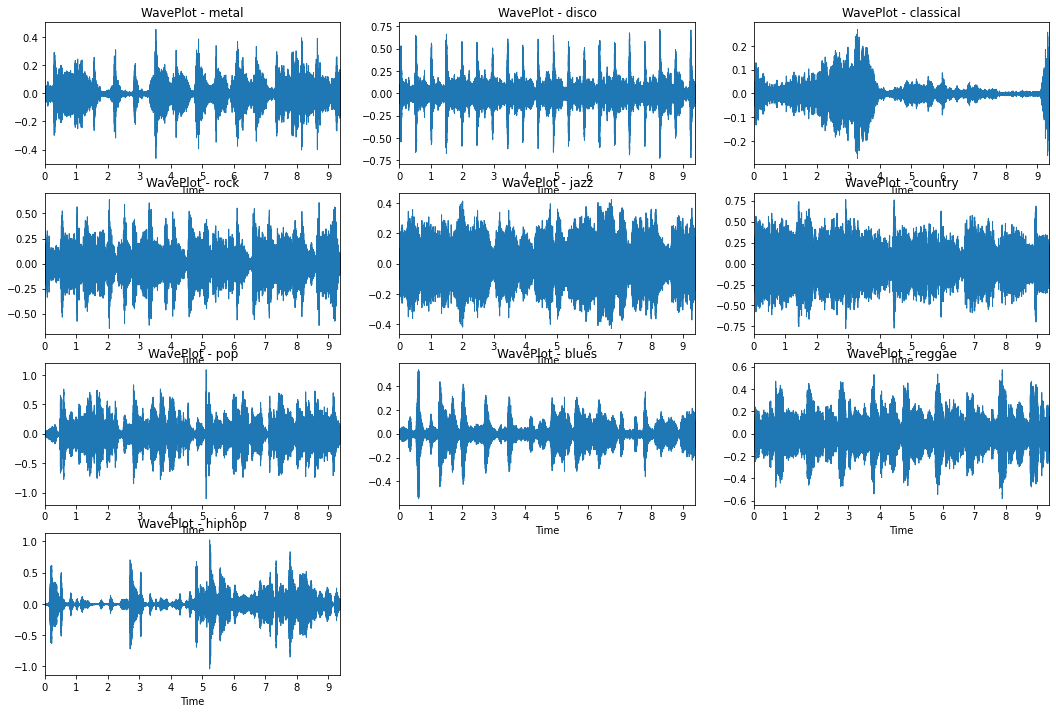

-------------------------------ReConstruction of Training Samples for Level: 1-------------------------------
Reconstructed Output:  (10, 28160, 1)
X':  [-0.00397447 -0.00826465 -0.00519556 ... -0.00143612 -0.00705813
 -0.00709087]
X range: [0.8076840043067932, -0.8071807026863098]


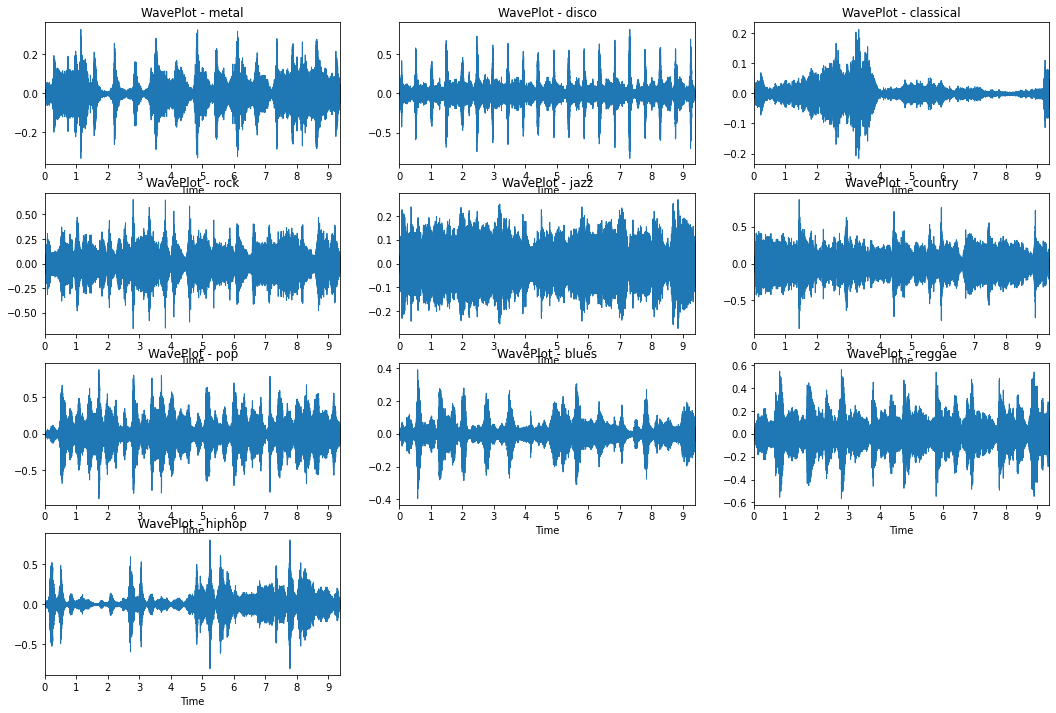

113/113 [==============================] - 28s 248ms/step - loss: 1.3360 - recon_loss: 0.0379 - vqvae_loss: 0.1295 - spectral_loss: 1.1655 - [0]level_loss: 0.6050 - [0]recon_loss: 0.0083 - [0]vq_loss: 0.1156 - [0]spectral_loss: 0.4811 - [0]batch_codebook_usage: 489.0428 - [0]codebook_usage: 512.0000 - [0]codebook_entropy: 5.8054 - [1]level_loss: 0.7277 - [1]recon_loss: 0.0293 - [1]vq_loss: 0.0140 - [1]spectral_loss: 0.6843 - [1]batch_codebook_usage: 310.4163 - [1]codebook_usage: 297.9430 - [1]codebook_entropy: 5.4200 - lr: 5.0000e-04
Epoch 57/100
113/113 [==============================] - ETA: 0s - loss: 1.3360 - recon_loss: 0.0369 - vqvae_loss: 0.1296 - spectral_loss: 1.1654 - [0]level_loss: 0.6057 - [0]recon_loss: 0.0083 - [0]vq_loss: 0.1166 - [0]spectral_loss: 0.4808 - [0]batch_codebook_usage: 489.7282 - [0]codebook_usage: 512.0000 - [0]codebook_entropy: 5.7957 - [1]level_loss: 0.7285 - [1]recon_loss: 0.0294 - [1]vq_loss: 0.0145 - [1]spectral_loss: 0.6846 - [1]batch_codebook_usage: 

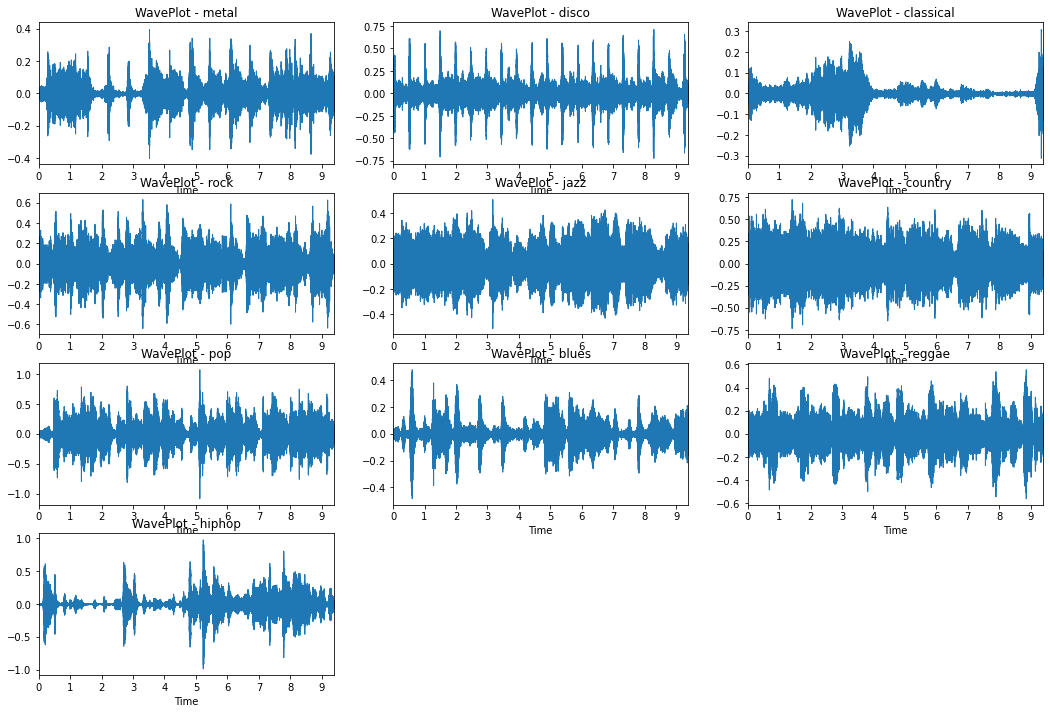

-------------------------------ReConstruction of Training Samples for Level: 1-------------------------------
Reconstructed Output:  (10, 28160, 1)
X':  [-0.01046202 -0.01292482 -0.00948946 ...  0.00240701  0.0026711
  0.00126534]
X range: [0.708580732345581, -0.6517393589019775]


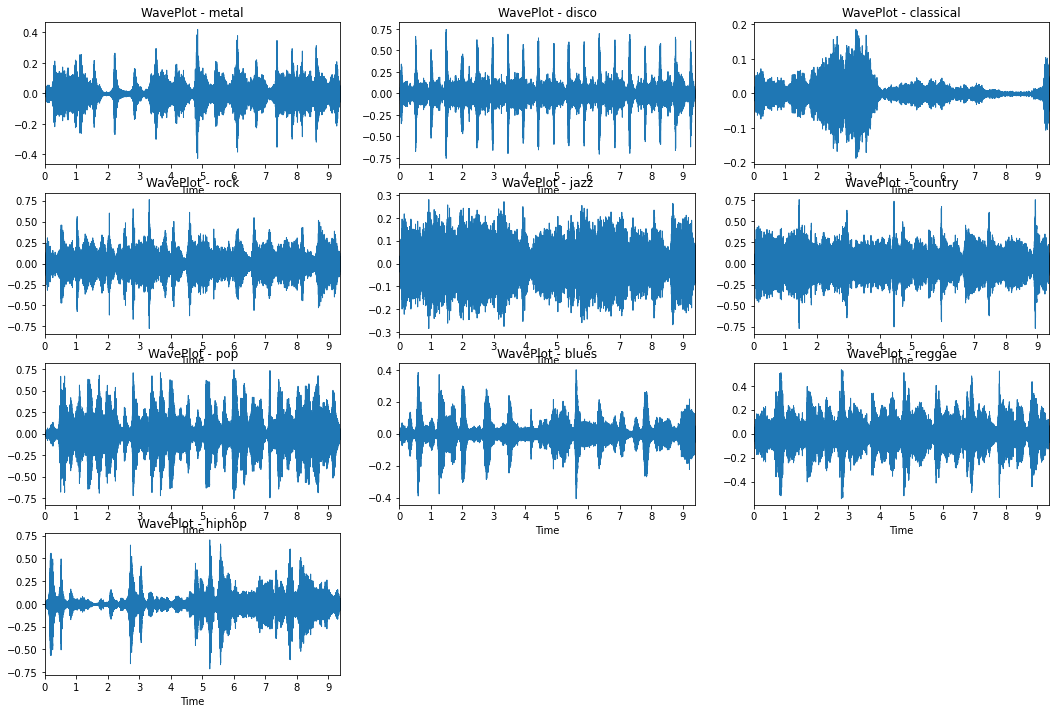

113/113 [==============================] - 29s 257ms/step - loss: 1.3277 - recon_loss: 0.0384 - vqvae_loss: 0.1319 - spectral_loss: 1.1627 - [0]level_loss: 0.6053 - [0]recon_loss: 0.0083 - [0]vq_loss: 0.1170 - [0]spectral_loss: 0.4800 - [0]batch_codebook_usage: 492.6875 - [0]codebook_usage: 512.0000 - [0]codebook_entropy: 5.8128 - [1]level_loss: 0.7270 - [1]recon_loss: 0.0294 - [1]vq_loss: 0.0149 - [1]spectral_loss: 0.6827 - [1]batch_codebook_usage: 312.8983 - [1]codebook_usage: 295.4979 - [1]codebook_entropy: 5.4355 - lr: 5.0000e-04
Epoch 62/100
113/113 [==============================] - ETA: 0s - loss: 1.3399 - recon_loss: 0.0376 - vqvae_loss: 0.1306 - spectral_loss: 1.1608 - [0]level_loss: 0.6062 - [0]recon_loss: 0.0083 - [0]vq_loss: 0.1168 - [0]spectral_loss: 0.4811 - [0]batch_codebook_usage: 487.8434 - [0]codebook_usage: 512.0000 - [0]codebook_entropy: 5.7977 - [1]level_loss: 0.7240 - [1]recon_loss: 0.0294 - [1]vq_loss: 0.0149 - [1]spectral_loss: 0.6797 - [1]batch_codebook_usage: 

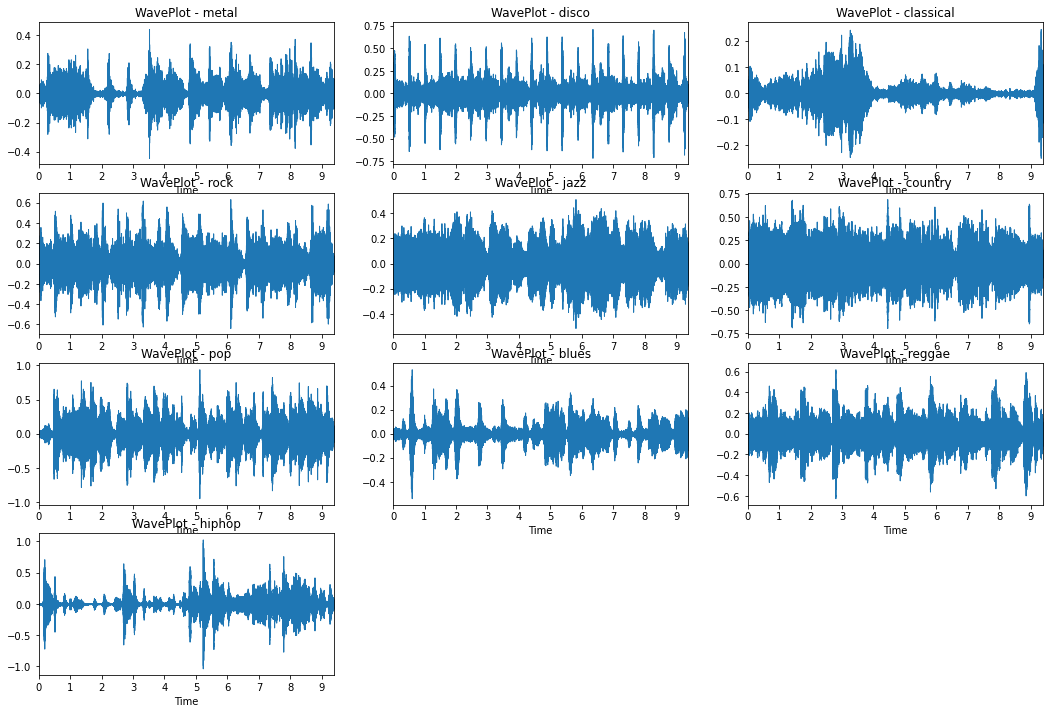

-------------------------------ReConstruction of Training Samples for Level: 1-------------------------------
Reconstructed Output:  (10, 28160, 1)
X':  [ 0.0013276  -0.00066488 -0.00201374 ... -0.00222487 -0.01066301
 -0.00737543]
X range: [0.6271126866340637, -0.6425233483314514]


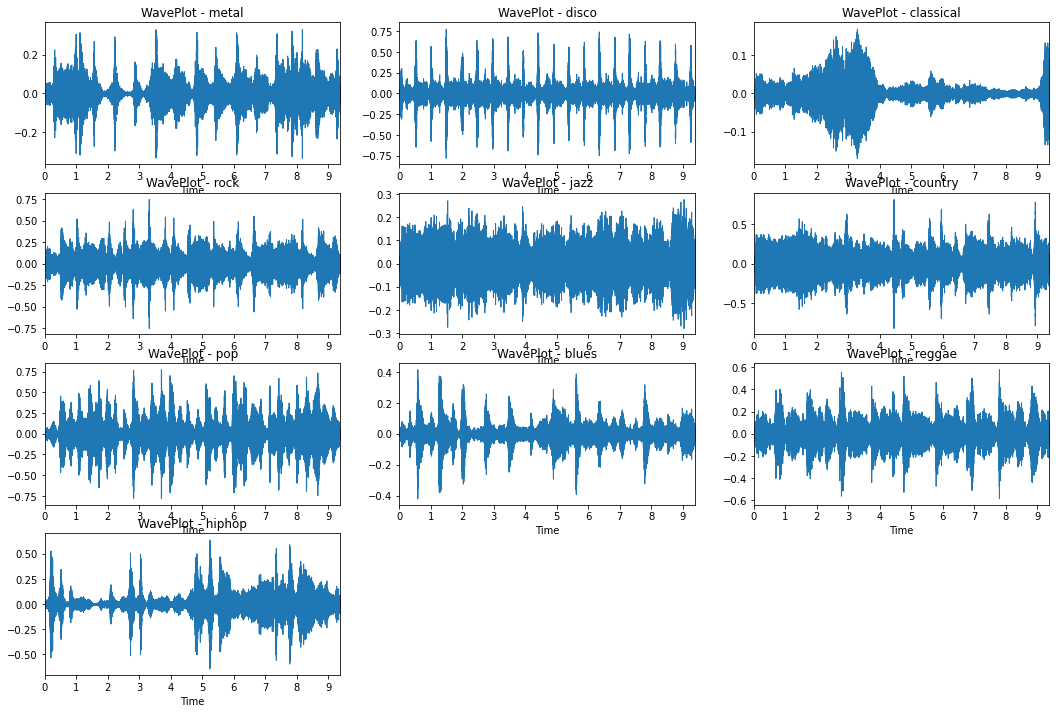

113/113 [==============================] - 30s 265ms/step - loss: 1.3319 - recon_loss: 0.0381 - vqvae_loss: 0.1345 - spectral_loss: 1.1561 - [0]level_loss: 0.6045 - [0]recon_loss: 0.0082 - [0]vq_loss: 0.1187 - [0]spectral_loss: 0.4775 - [0]batch_codebook_usage: 484.9094 - [0]codebook_usage: 512.0000 - [0]codebook_entropy: 5.7868 - [1]level_loss: 0.7235 - [1]recon_loss: 0.0294 - [1]vq_loss: 0.0156 - [1]spectral_loss: 0.6786 - [1]batch_codebook_usage: 313.2350 - [1]codebook_usage: 294.4915 - [1]codebook_entropy: 5.4484 - lr: 5.0000e-04
Epoch 67/100
113/113 [==============================] - ETA: 0s - loss: 1.3300 - recon_loss: 0.0388 - vqvae_loss: 0.1374 - spectral_loss: 1.1537 - [0]level_loss: 0.6044 - [0]recon_loss: 0.0082 - [0]vq_loss: 0.1188 - [0]spectral_loss: 0.4774 - [0]batch_codebook_usage: 489.2180 - [0]codebook_usage: 512.0000 - [0]codebook_entropy: 5.8094 - [1]level_loss: 0.7217 - [1]recon_loss: 0.0294 - [1]vq_loss: 0.0159 - [1]spectral_loss: 0.6763 - [1]batch_codebook_usage: 

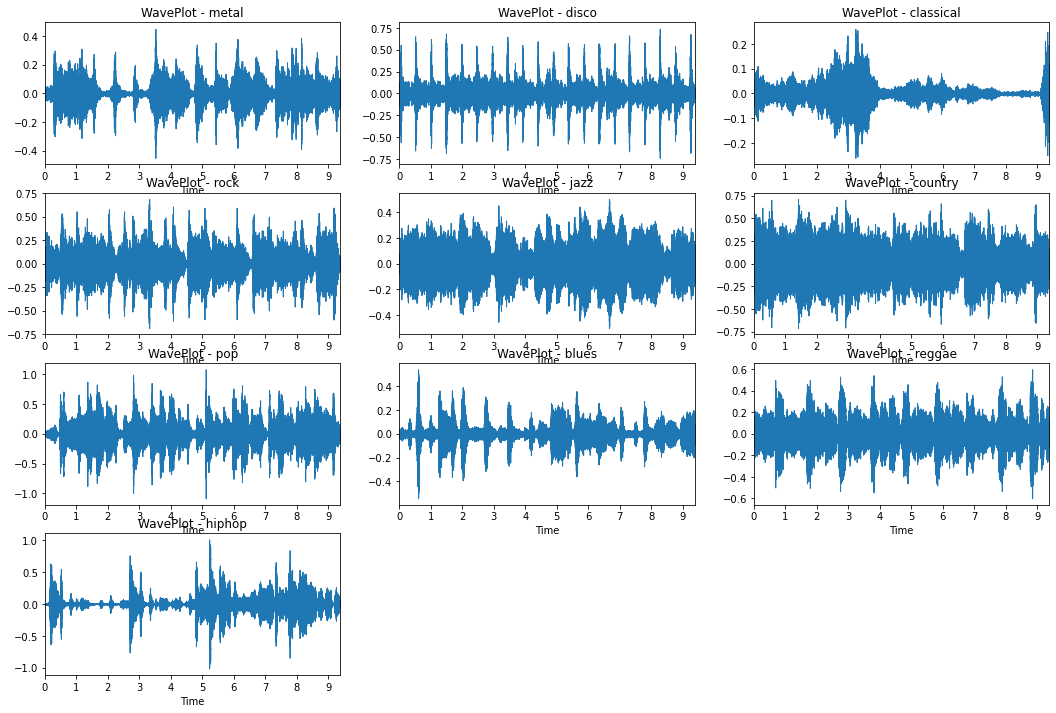

-------------------------------ReConstruction of Training Samples for Level: 1-------------------------------
Reconstructed Output:  (10, 28160, 1)
X':  [-0.00789027 -0.00926467 -0.00505415 ...  0.01070384  0.01126692
  0.01362976]
X range: [0.7728838920593262, -0.6842809915542603]


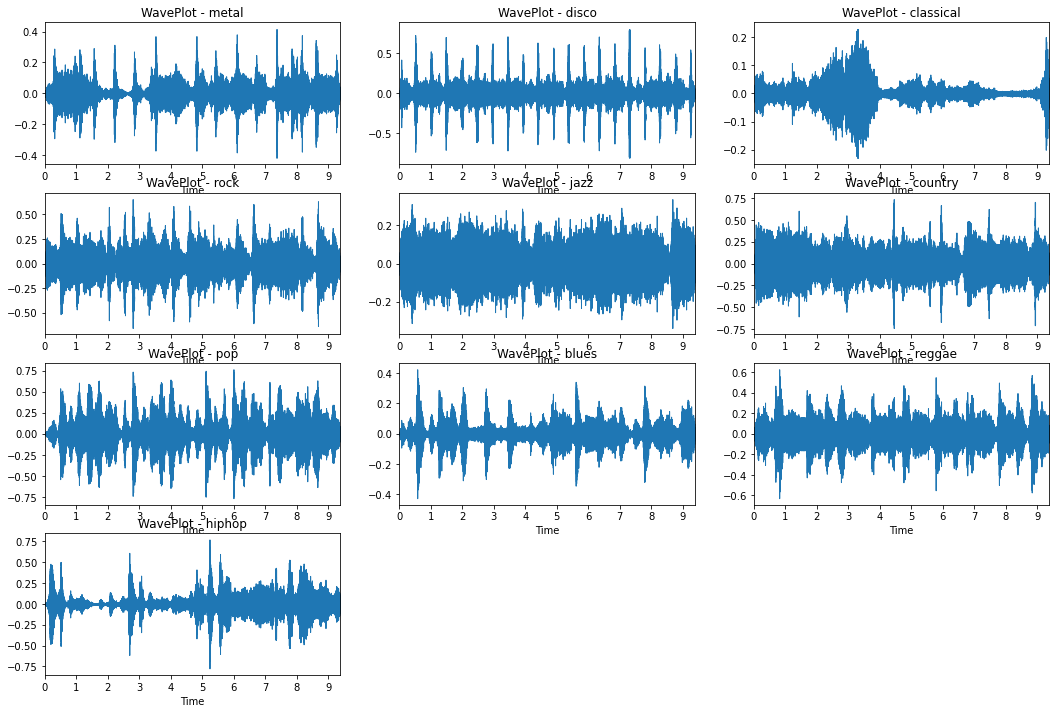

113/113 [==============================] - 30s 266ms/step - loss: 1.3282 - recon_loss: 0.0364 - vqvae_loss: 0.1354 - spectral_loss: 1.1523 - [0]level_loss: 0.6030 - [0]recon_loss: 0.0082 - [0]vq_loss: 0.1195 - [0]spectral_loss: 0.4753 - [0]batch_codebook_usage: 488.4701 - [0]codebook_usage: 512.0000 - [0]codebook_entropy: 5.7732 - [1]level_loss: 0.7234 - [1]recon_loss: 0.0293 - [1]vq_loss: 0.0171 - [1]spectral_loss: 0.6770 - [1]batch_codebook_usage: 313.2896 - [1]codebook_usage: 302.8805 - [1]codebook_entropy: 5.4307 - lr: 5.0000e-04
Epoch 72/100
113/113 [==============================] - ETA: 0s - loss: 1.3318 - recon_loss: 0.0380 - vqvae_loss: 0.1381 - spectral_loss: 1.1526 - [0]level_loss: 0.6035 - [0]recon_loss: 0.0082 - [0]vq_loss: 0.1206 - [0]spectral_loss: 0.4747 - [0]batch_codebook_usage: 488.6865 - [0]codebook_usage: 512.0000 - [0]codebook_entropy: 5.7903 - [1]level_loss: 0.7243 - [1]recon_loss: 0.0294 - [1]vq_loss: 0.0170 - [1]spectral_loss: 0.6779 - [1]batch_codebook_usage: 

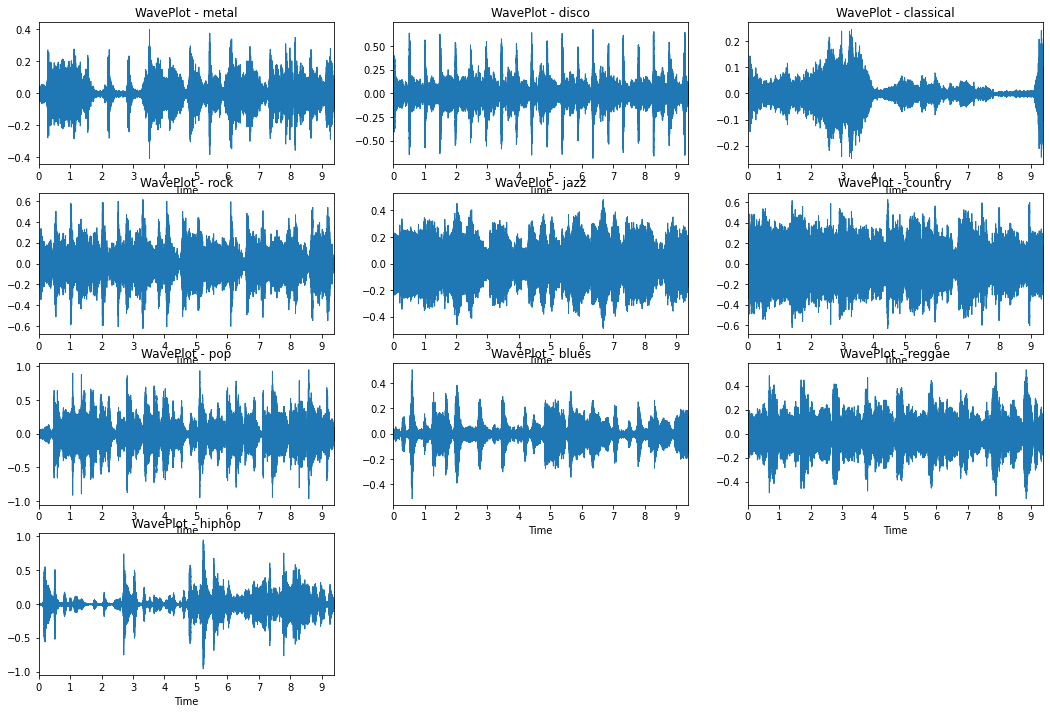

-------------------------------ReConstruction of Training Samples for Level: 1-------------------------------
Reconstructed Output:  (10, 28160, 1)
X':  [-0.01296978 -0.01067524 -0.00641417 ...  0.00526889 -0.00031921
  0.00446155]
X range: [0.7429794073104858, -0.7839159369468689]


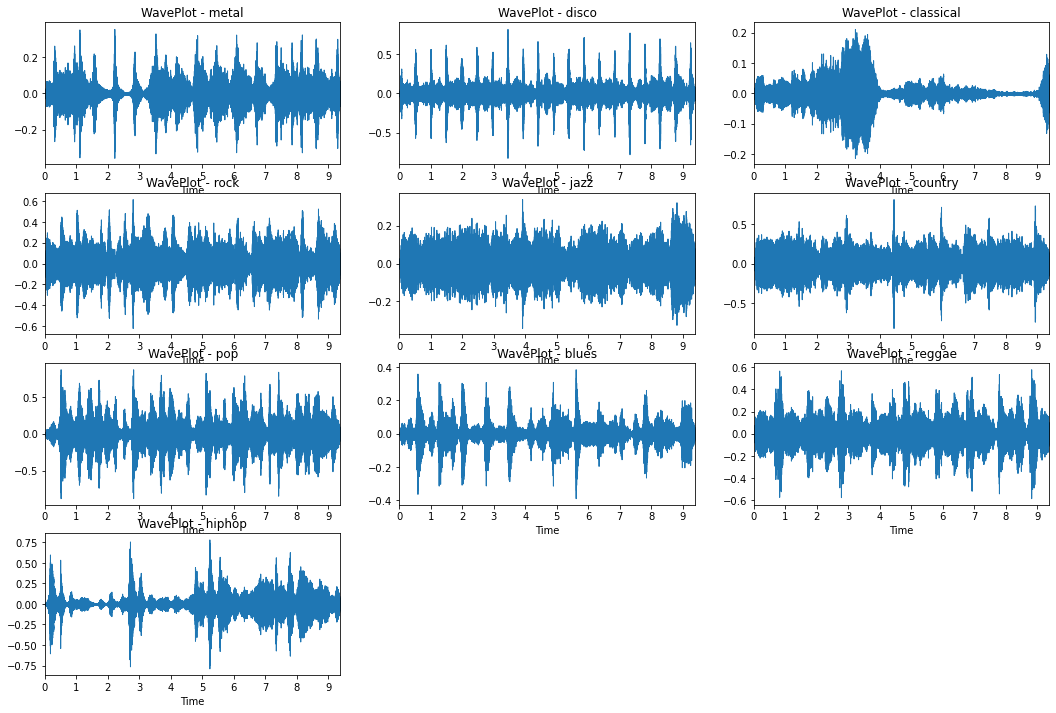

113/113 [==============================] - 28s 252ms/step - loss: 1.3298 - recon_loss: 0.0385 - vqvae_loss: 0.1348 - spectral_loss: 1.1452 - [0]level_loss: 0.6009 - [0]recon_loss: 0.0082 - [0]vq_loss: 0.1204 - [0]spectral_loss: 0.4723 - [0]batch_codebook_usage: 487.0684 - [0]codebook_usage: 512.0000 - [0]codebook_entropy: 5.7561 - [1]level_loss: 0.7198 - [1]recon_loss: 0.0295 - [1]vq_loss: 0.0174 - [1]spectral_loss: 0.6729 - [1]batch_codebook_usage: 309.6616 - [1]codebook_usage: 300.6176 - [1]codebook_entropy: 5.4211 - lr: 5.0000e-04
Epoch 77/100
113/113 [==============================] - ETA: 0s - loss: 1.3268 - recon_loss: 0.0376 - vqvae_loss: 0.1370 - spectral_loss: 1.1430 - [0]level_loss: 0.6016 - [0]recon_loss: 0.0082 - [0]vq_loss: 0.1210 - [0]spectral_loss: 0.4723 - [0]batch_codebook_usage: 489.0207 - [0]codebook_usage: 511.9971 - [0]codebook_entropy: 5.7887 - [1]level_loss: 0.7176 - [1]recon_loss: 0.0293 - [1]vq_loss: 0.0177 - [1]spectral_loss: 0.6706 - [1]batch_codebook_usage: 

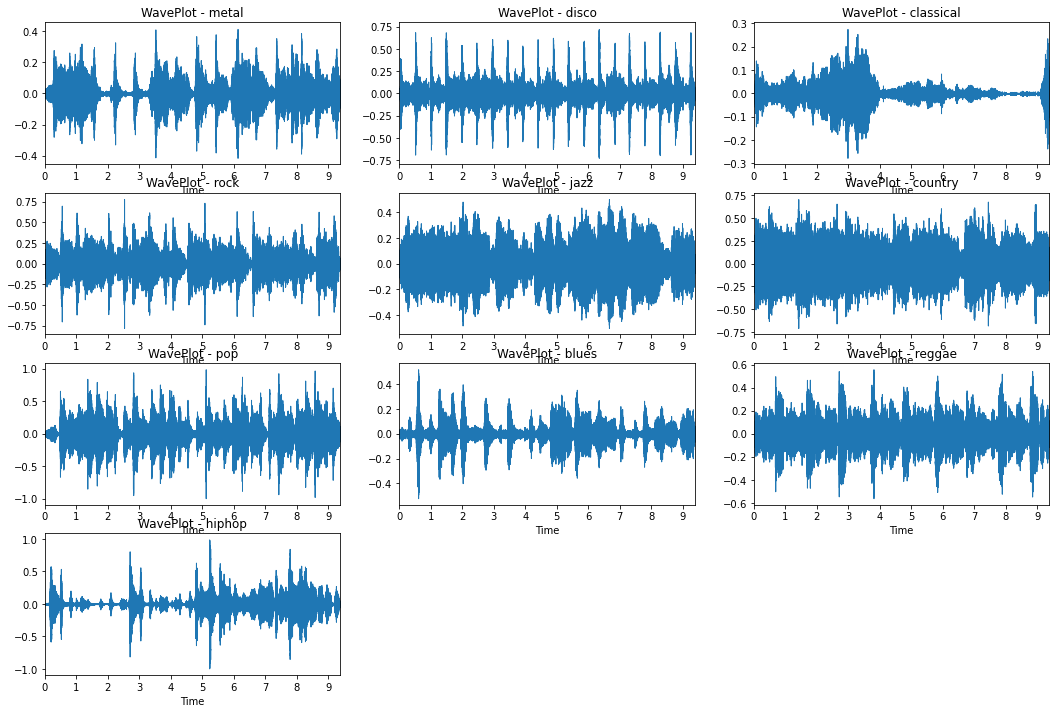

-------------------------------ReConstruction of Training Samples for Level: 1-------------------------------
Reconstructed Output:  (10, 28160, 1)
X':  [-0.0022273  -0.00776192 -0.00705866 ... -0.00063528 -0.00151963
  0.00271302]
X range: [0.9636241793632507, -0.8821347951889038]


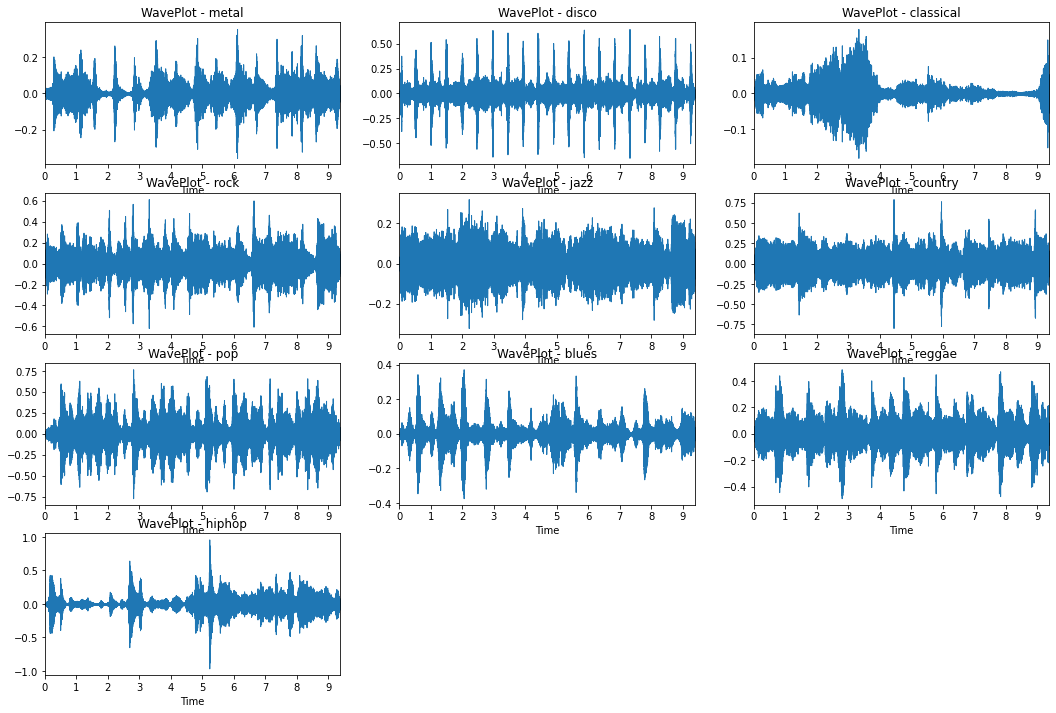

113/113 [==============================] - 30s 264ms/step - loss: 1.3232 - recon_loss: 0.0346 - vqvae_loss: 0.1397 - spectral_loss: 1.1367 - [0]level_loss: 0.6009 - [0]recon_loss: 0.0082 - [0]vq_loss: 0.1228 - [0]spectral_loss: 0.4699 - [0]batch_codebook_usage: 484.7340 - [0]codebook_usage: 512.0000 - [0]codebook_entropy: 5.7502 - [1]level_loss: 0.7140 - [1]recon_loss: 0.0294 - [1]vq_loss: 0.0178 - [1]spectral_loss: 0.6668 - [1]batch_codebook_usage: 315.8797 - [1]codebook_usage: 308.3743 - [1]codebook_entropy: 5.4379 - lr: 5.0000e-04
Epoch 82/100
113/113 [==============================] - ETA: 0s - loss: 1.3158 - recon_loss: 0.0349 - vqvae_loss: 0.1396 - spectral_loss: 1.1366 - [0]level_loss: 0.6004 - [0]recon_loss: 0.0083 - [0]vq_loss: 0.1223 - [0]spectral_loss: 0.4699 - [0]batch_codebook_usage: 486.9172 - [0]codebook_usage: 511.9888 - [0]codebook_entropy: 5.7766 - [1]level_loss: 0.7139 - [1]recon_loss: 0.0294 - [1]vq_loss: 0.0178 - [1]spectral_loss: 0.6667 - [1]batch_codebook_usage: 

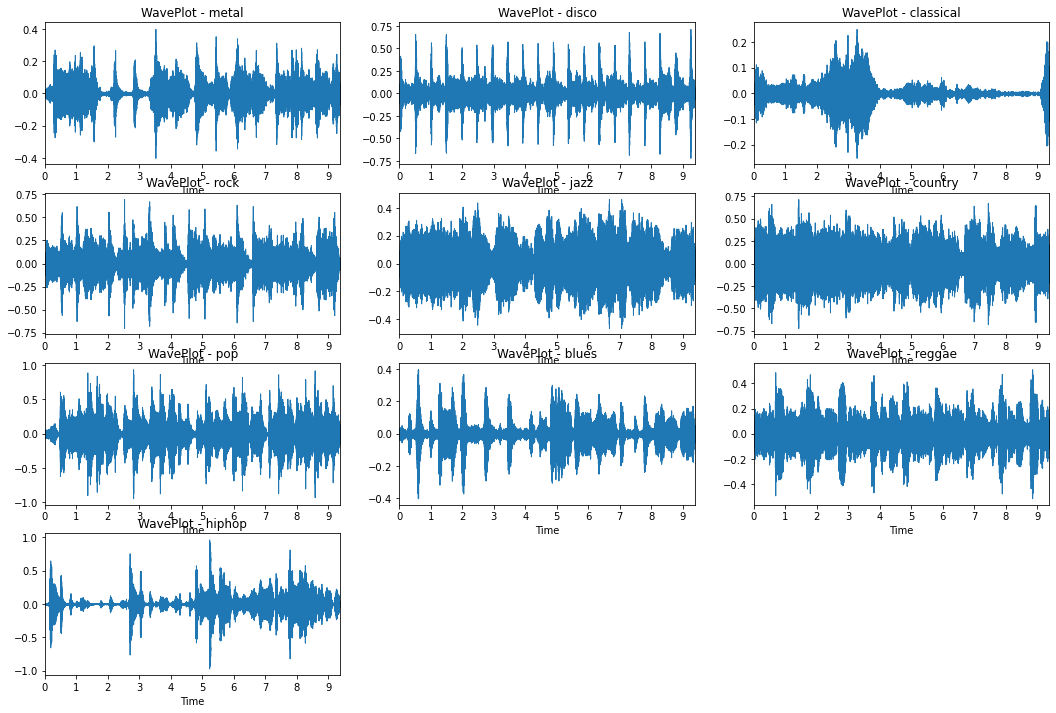

-------------------------------ReConstruction of Training Samples for Level: 1-------------------------------
Reconstructed Output:  (10, 28160, 1)
X':  [-0.00393931 -0.00650681 -0.00564547 ...  0.0001123  -0.0019869
  0.0014044 ]
X range: [0.6133866310119629, -0.6529176235198975]


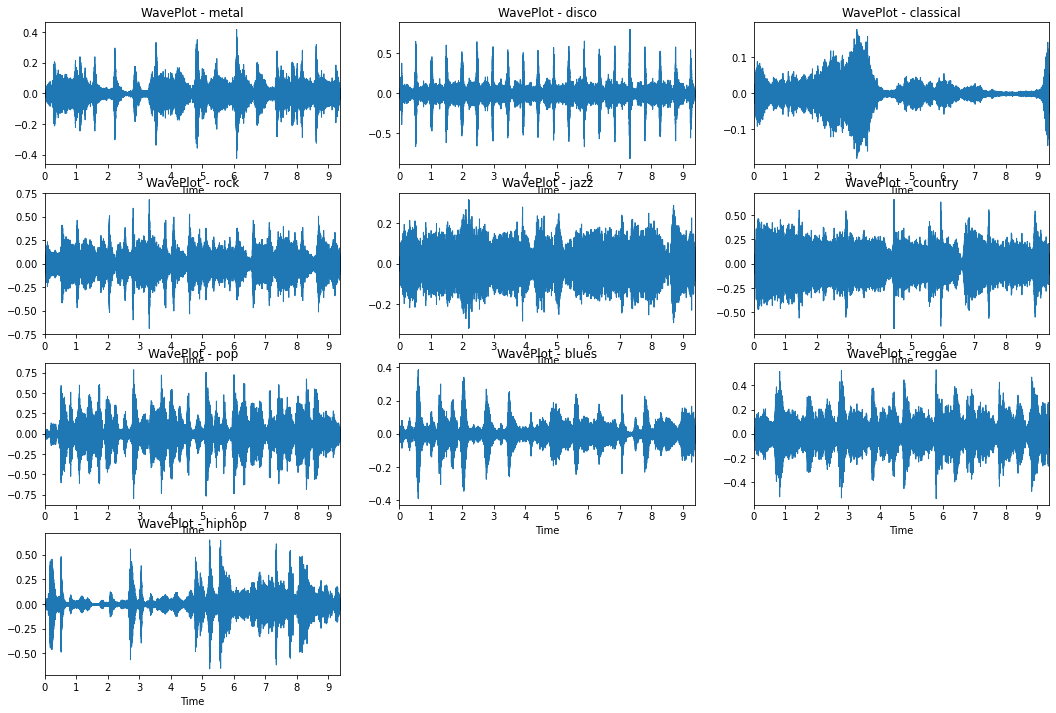

113/113 [==============================] - 30s 262ms/step - loss: 1.3449 - recon_loss: 0.0364 - vqvae_loss: 0.1425 - spectral_loss: 1.1489 - [0]level_loss: 0.6006 - [0]recon_loss: 0.0083 - [0]vq_loss: 0.1238 - [0]spectral_loss: 0.4685 - [0]batch_codebook_usage: 487.2665 - [0]codebook_usage: 512.0000 - [0]codebook_entropy: 5.7730 - [1]level_loss: 0.7299 - [1]recon_loss: 0.0295 - [1]vq_loss: 0.0200 - [1]spectral_loss: 0.6804 - [1]batch_codebook_usage: 313.8172 - [1]codebook_usage: 335.7201 - [1]codebook_entropy: 5.4290 - lr: 5.0000e-04
Epoch 87/100
113/113 [==============================] - ETA: 0s - loss: 1.3250 - recon_loss: 0.0363 - vqvae_loss: 0.1431 - spectral_loss: 1.1319 - [0]level_loss: 0.5989 - [0]recon_loss: 0.0082 - [0]vq_loss: 0.1243 - [0]spectral_loss: 0.4664 - [0]batch_codebook_usage: 488.3124 - [0]codebook_usage: 512.0000 - [0]codebook_entropy: 5.7852 - [1]level_loss: 0.7145 - [1]recon_loss: 0.0294 - [1]vq_loss: 0.0196 - [1]spectral_loss: 0.6655 - [1]batch_codebook_usage: 

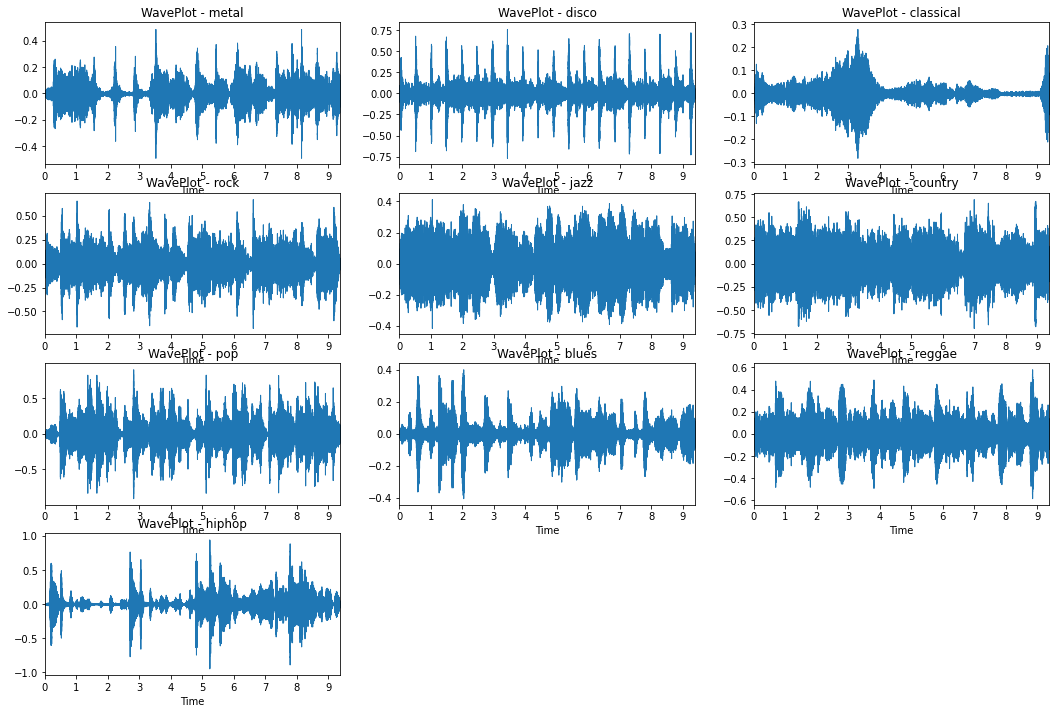

-------------------------------ReConstruction of Training Samples for Level: 1-------------------------------
Reconstructed Output:  (10, 28160, 1)
X':  [ 0.00053898 -0.00042061 -0.00073902 ...  0.00989294  0.00930816
  0.01417948]
X range: [0.7116973400115967, -0.7229245901107788]


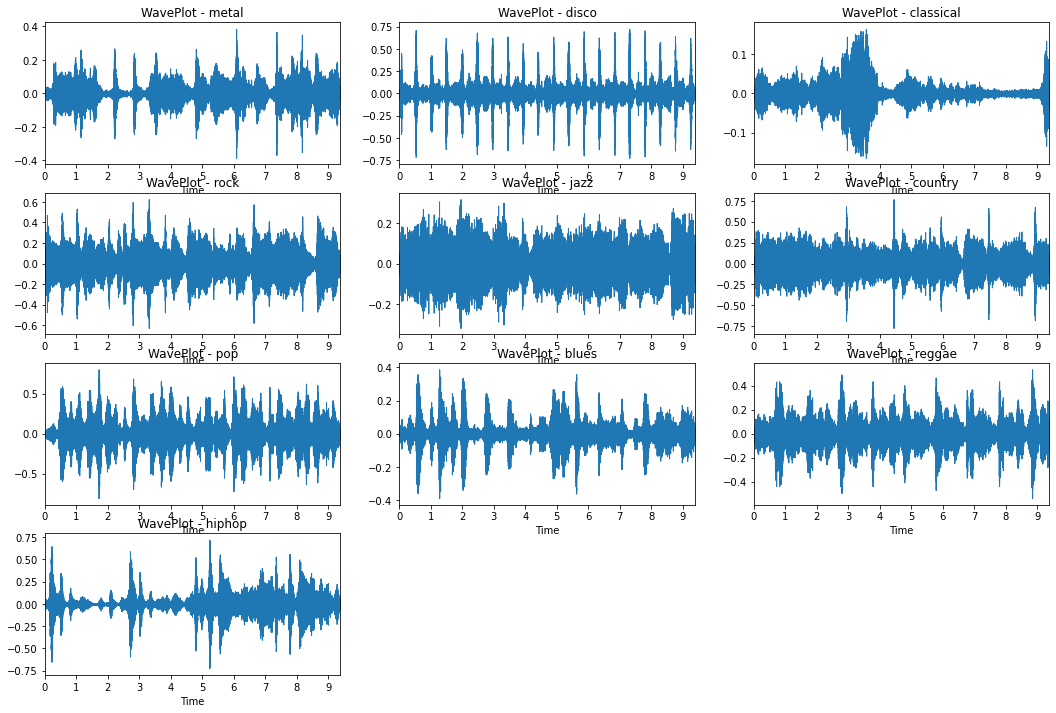

113/113 [==============================] - 28s 246ms/step - loss: 1.3136 - recon_loss: 0.0393 - vqvae_loss: 0.1485 - spectral_loss: 1.1302 - [0]level_loss: 0.6005 - [0]recon_loss: 0.0083 - [0]vq_loss: 0.1251 - [0]spectral_loss: 0.4672 - [0]batch_codebook_usage: 488.2275 - [0]codebook_usage: 512.0000 - [0]codebook_entropy: 5.7917 - [1]level_loss: 0.7118 - [1]recon_loss: 0.0293 - [1]vq_loss: 0.0195 - [1]spectral_loss: 0.6630 - [1]batch_codebook_usage: 319.5507 - [1]codebook_usage: 315.8340 - [1]codebook_entropy: 5.4745 - lr: 5.0000e-04
Epoch 92/100
113/113 [==============================] - ETA: 0s - loss: 1.3072 - recon_loss: 0.0384 - vqvae_loss: 0.1412 - spectral_loss: 1.1289 - [0]level_loss: 0.5985 - [0]recon_loss: 0.0083 - [0]vq_loss: 0.1244 - [0]spectral_loss: 0.4658 - [0]batch_codebook_usage: 487.1714 - [0]codebook_usage: 512.0000 - [0]codebook_entropy: 5.7628 - [1]level_loss: 0.7119 - [1]recon_loss: 0.0295 - [1]vq_loss: 0.0192 - [1]spectral_loss: 0.6631 - [1]batch_codebook_usage: 

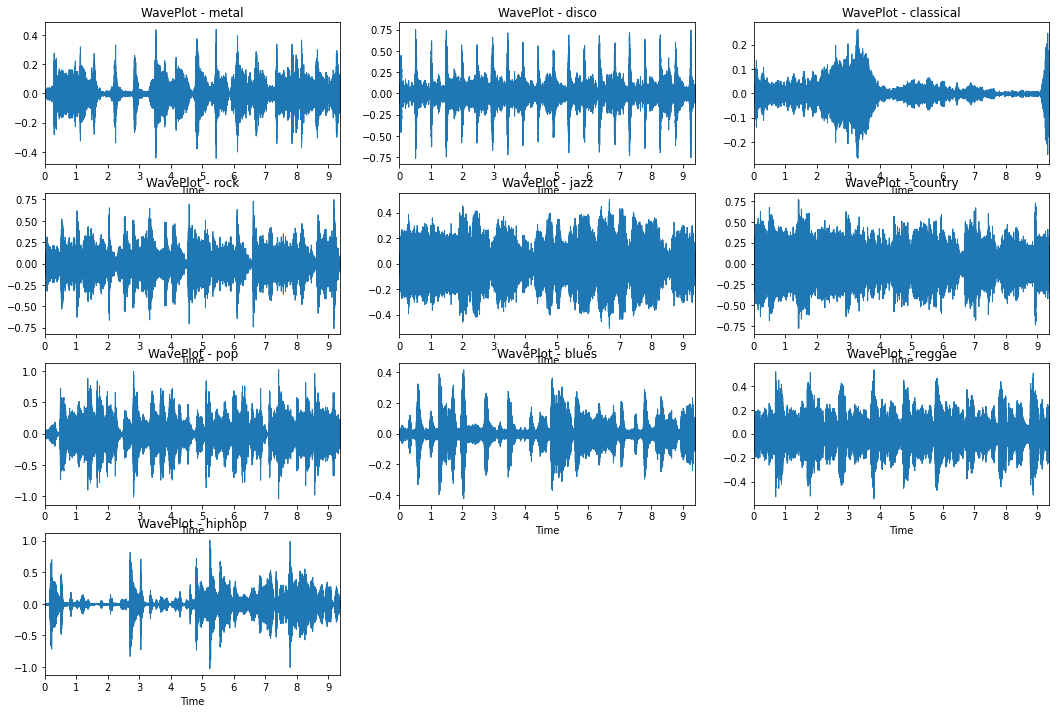

-------------------------------ReConstruction of Training Samples for Level: 1-------------------------------
Reconstructed Output:  (10, 28160, 1)
X':  [-0.00185651 -0.00203509 -0.00261321 ... -0.01389619 -0.00478371
  0.0007515 ]
X range: [0.7082545757293701, -0.6935265064239502]


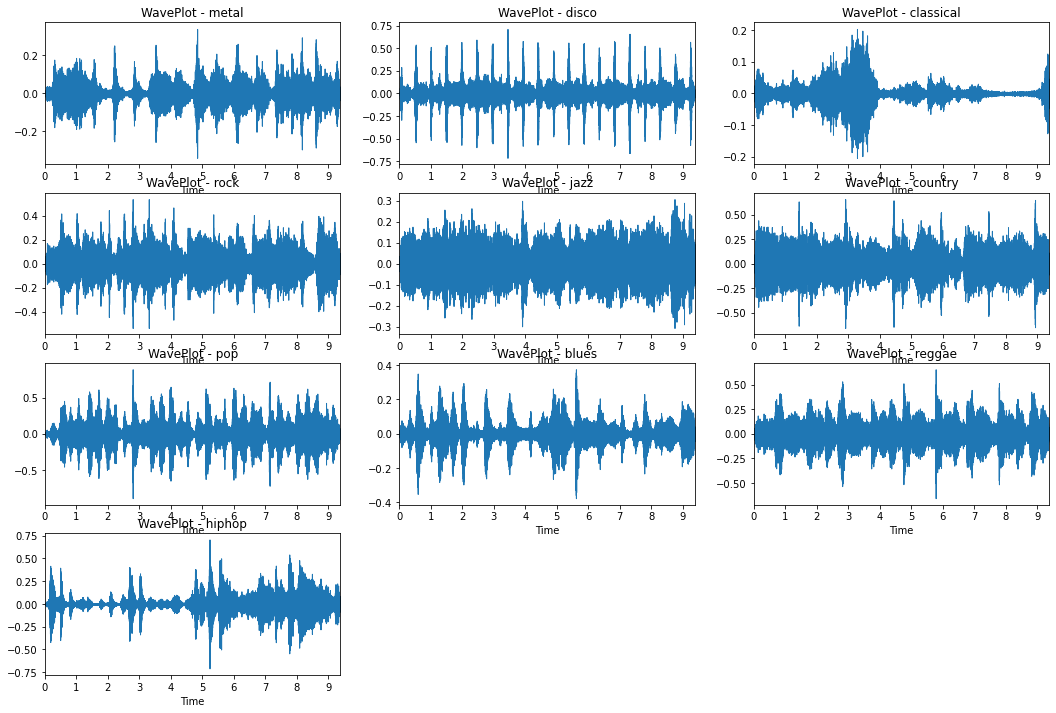

113/113 [==============================] - 28s 247ms/step - loss: 1.3117 - recon_loss: 0.0353 - vqvae_loss: 0.1474 - spectral_loss: 1.1204 - [0]level_loss: 0.5986 - [0]recon_loss: 0.0083 - [0]vq_loss: 0.1269 - [0]spectral_loss: 0.4634 - [0]batch_codebook_usage: 487.4382 - [0]codebook_usage: 512.0000 - [0]codebook_entropy: 5.7685 - [1]level_loss: 0.7066 - [1]recon_loss: 0.0296 - [1]vq_loss: 0.0200 - [1]spectral_loss: 0.6571 - [1]batch_codebook_usage: 320.3280 - [1]codebook_usage: 322.7179 - [1]codebook_entropy: 5.4702 - lr: 5.0000e-04
Epoch 97/100
113/113 [==============================] - ETA: 0s - loss: 1.3057 - recon_loss: 0.0397 - vqvae_loss: 0.1432 - spectral_loss: 1.1249 - [0]level_loss: 0.5976 - [0]recon_loss: 0.0082 - [0]vq_loss: 0.1241 - [0]spectral_loss: 0.4653 - [0]batch_codebook_usage: 487.9975 - [0]codebook_usage: 512.0000 - [0]codebook_entropy: 5.7490 - [1]level_loss: 0.7091 - [1]recon_loss: 0.0295 - [1]vq_loss: 0.0199 - [1]spectral_loss: 0.6596 - [1]batch_codebook_usage: 

In [106]:
# Callback 0: Learning Rate Scheduler
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='loss', factor=0.5, patience=50, verbose=1, min_lr=0.0000001, min_delta=1.0)
vqvae_trainer.compile(optimizer=keras.optimizers.Adam()) # 15e-5 for jukebox paper ('vqvae' model)

vqvae_trainer.fit(train_dataset, epochs=100, callbacks=[vae_monitor, reduce_lr])

[DEBUG] TOTAL Number of Trainable Weights for model: 302337
Reconstructed Output:  (10, 28160, 1)
X':  [ 7.1000298e-03 -7.6710596e-05 -4.4811210e-03 ... -9.0373214e-03
 -7.8270612e-03  4.1565662e-03]
X range: [0.9253488183021545, -0.9790224432945251]


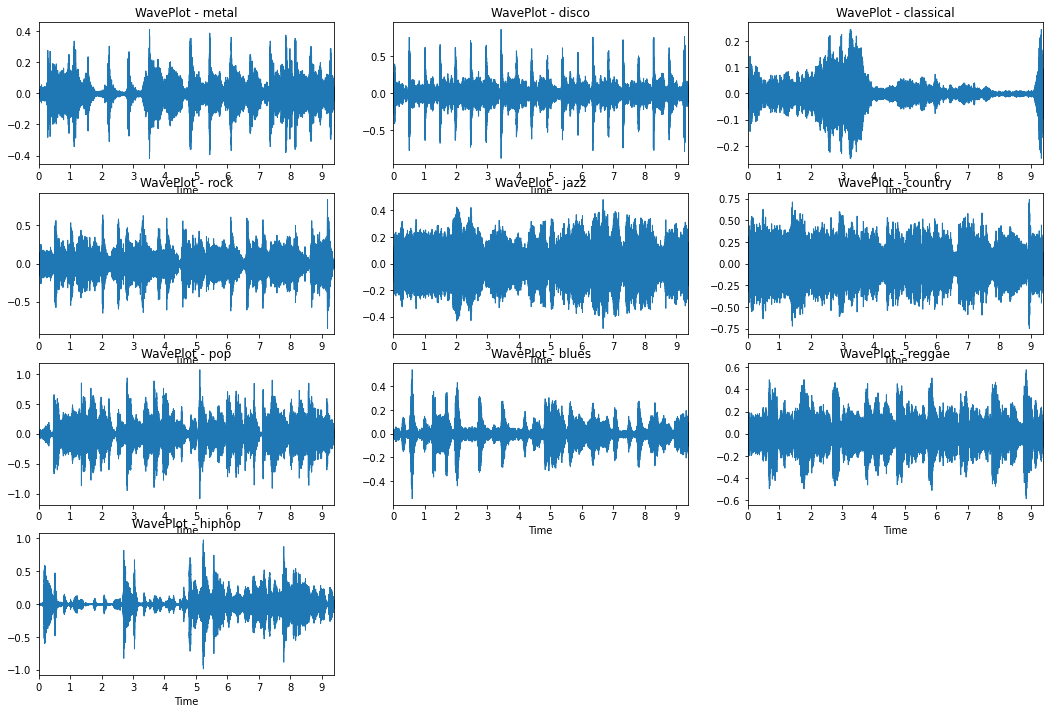

In [127]:
#### Inspect reconstructed sample
# recon_train_samples = generate_and_save_waves(vqvae_trainer, 0, train_samples) #TODO: need to assign which level of vqvae...
recon_train_samples_bottom = generate_and_save_waves(vqvae_trainer.vqvaes[0], 0, train_samples) #TODO: need to assign which level of vqvae...

In [ ]:
### Middle Level (TODO)

[DEBUG] TOTAL Number of Trainable Weights for model: 496705
Reconstructed Output:  (10, 28160, 1)
X':  [-0.01535386 -0.00497422 -0.00174043 ...  0.00612009  0.00322037
  0.00541479]
X range: [0.8396671414375305, -0.871154248714447]


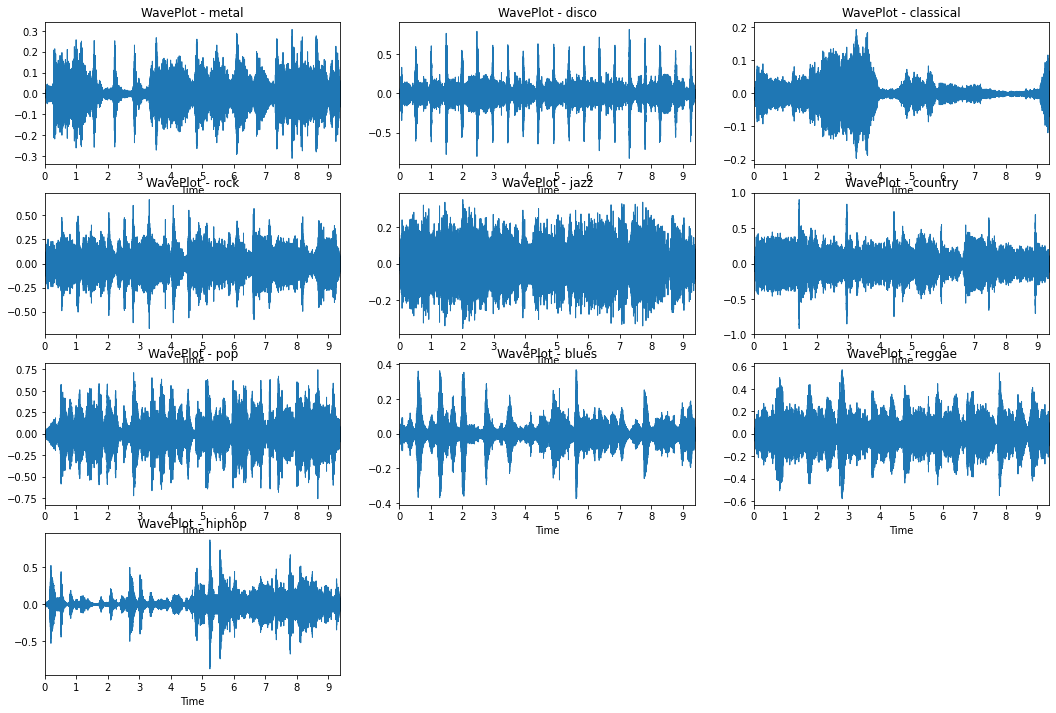

In [123]:
### TOP Leve
recon_train_samples_top = generate_and_save_waves(vqvae_trainer.vqvaes[1], 0, train_samples) #TODO: need to assign which level of vqvae...

In [120]:
ipd.Audio(train_samples[2].squeeze(), rate=SAMPLE_RATE)

In [125]:
ipd.Audio(recon_train_samples_bottom[9].squeeze(), rate=SAMPLE_RATE) # Metal Recon

In [124]:
ipd.Audio(recon_train_samples_top[9].squeeze(), rate=SAMPLE_RATE) # Metal Recon

## Storage, Checkpointing...

In [121]:
VERSION = "double_separate_vqvae"
local_storage_path = './colab_storage/VQVAE/cp/{}/'.format(VERSION)

In [162]:
# vqvae_trainer.save(local_storage_path)
for level in range(vqvae_trainer.levels):
    # vqvae_trainer.encoders[level].save_weights("{}{}/{}".format(local_storage_path, "encoder", level))
    # vqvae_trainer.decoders[level].save_weights("{}{}/{}".format(local_storage_path, "decoder", level))
    # vqvae_trainer.vqs[level].save_weights("{}{}/{}".format(local_storage_path, "vq", level))
    vqvae_trainer.vqvaes[level].save_weights("{}{}/{}".format(local_storage_path, "vqvae", level))

In [163]:
loaded_vqvae_trainer = vqvae.VQVAE(sample_batch.shape[1:], levels=2, latent_dim=64, num_embeddings=512, down_depth=[5, 3], strides=[2, 2], dilation_factor=3, residual_width=32) # codebook size

Adding EncoderConvBlock: 0
Adding EncoderConvBlock: 0
Adding EncoderConvBlock: 1
Adding DecoderConvBlock: 0
Adding DecoderConvBlock: 1
Adding DecoderConvBlock: 0


In [164]:
loaded_vqvae_trainer.vqs[0].N_t
# Validation
initial_codebook = loaded_vqvae_trainer.vqs[0].embeddings.numpy()
initial_enc_weights = loaded_vqvae_trainer.encoders[0].get_weights() # already NP arr[w.numpy() for w in loaded_vqvae_trainer.encoders[0].get_weights()]
initial_dec_weights = loaded_vqvae_trainer.decoders[0].get_weights() #[w.numpy() for w in loaded_vqvae_trainer.decoders[0].get_weights()]

In [166]:
for level in range(loaded_vqvae_trainer.levels):
    # vqvae_trainer.encoders[level].save_weights("{}{}/{}".format(local_storage_path, "encoder", level))
    # vqvae_trainer.decoders[level].save_weights("{}{}/{}".format(local_storage_path, "decoder", level))
    # vqvae_trainer.vqs[level].save_weights("{}{}/{}".format(local_storage_path, "vq", level))
    print("--------- Loading Models from Level: {}".format(level))
    loaded_vqvae_trainer.vqvaes[level].load_weights("{}{}/{}".format(local_storage_path, "vqvae", level))

--------- Loading Models from Level: 0
--------- Loading Models from Level: 1


In [154]:
# loaded_codebook = loaded_vqvae_trainer.vqs[0].embeddings
# print(loaded_codebook == initial_codebook)
# loaded_enc_weights = loaded_vqvae_trainer.encoders[0].get_weights()
# for w1, w2 in zip(initial_enc_weights, loaded_enc_weights):
#   print(w1==w2)

Epoch 1/100
113/113 [==============================] - ETA: 0s - loss: 1.2836 - recon_loss: 0.0377 - vqvae_loss: 0.1608 - spectral_loss: 1.0781 - [0]level_loss: 0.5912 - [0]recon_loss: 0.0081 - [0]vq_loss: 0.1368 - [0]spectral_loss: 0.4462 - [0]batch_codebook_usage: 487.5071 - [0]codebook_usage: 512.0000 - [0]codebook_entropy: 5.7786 - [1]level_loss: 0.6856 - [1]recon_loss: 0.0292 - [1]vq_loss: 0.0244 - [1]spectral_loss: 0.6319 - [1]batch_codebook_usage: 328.3378 - [1]codebook_usage: 309.5329 - [1]codebook_entropy: 5.5052
-------------------------Epoch: 0, Level: 0------------------------------

[VQ DEBUG] Snap shot of N_t: 512.0; Code<=0... 0.0

Resetting the metrics...

-------------------------Epoch: 0, Level: 1------------------------------

[VQ DEBUG] Snap shot of N_t: 308.0; Code<=0... 0.0

Resetting the metrics...

[DEBUG] This is Callback Monitor: End of Epoch 0
---------------------------Running Validation DataSet---------------------------
13/13 [=============================

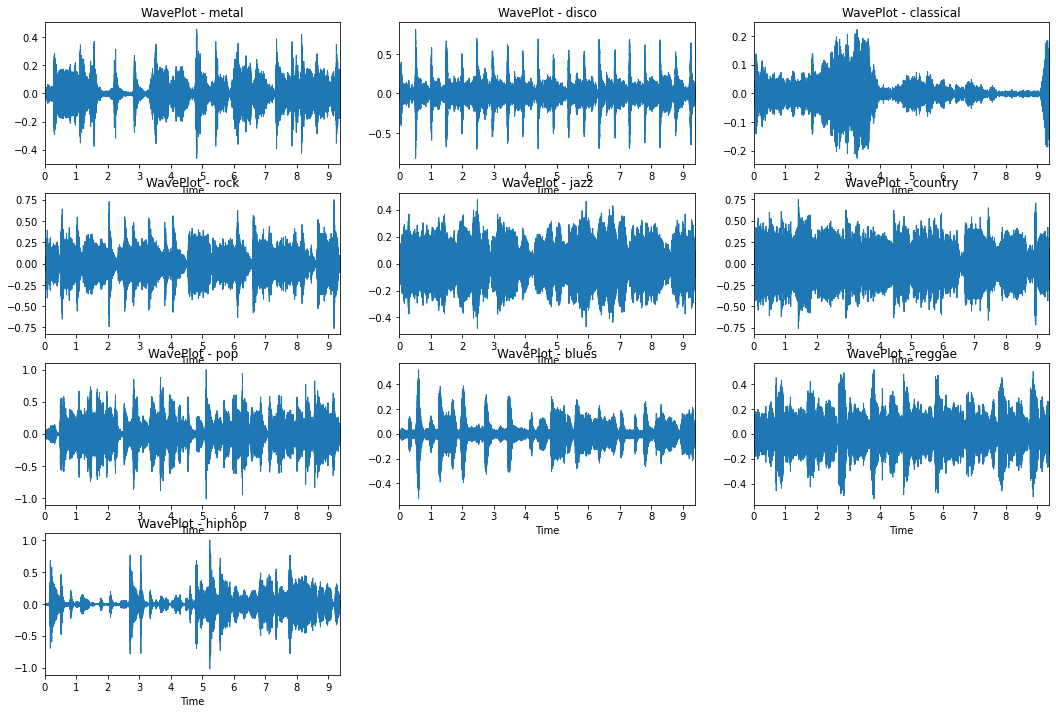

-------------------------------ReConstruction of Training Samples for Level: 1-------------------------------
[DEBUG] TOTAL Number of Trainable Weights for model: 496705
Reconstructed Output:  (10, 28160, 1)
X':  [-0.00180584 -0.0022254  -0.00141599 ... -0.01354532 -0.00920691
 -0.00178273]
X range: [0.9086863994598389, -0.845641553401947]


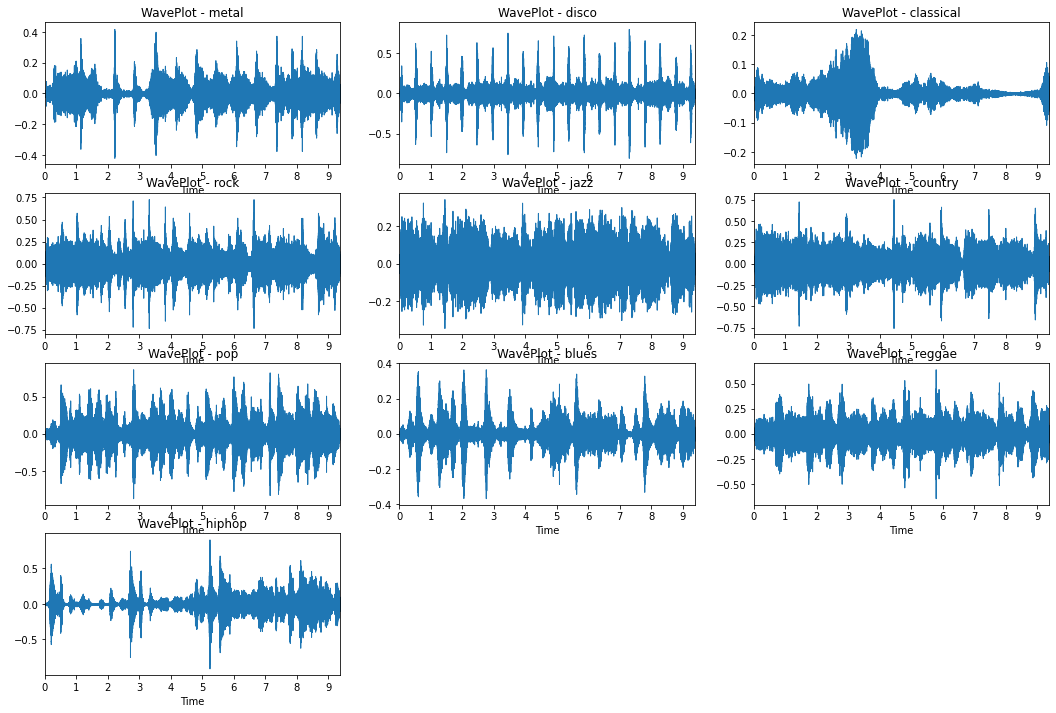

113/113 [==============================] - 56s 290ms/step - loss: 1.2836 - recon_loss: 0.0377 - vqvae_loss: 0.1608 - spectral_loss: 1.0781 - [0]level_loss: 0.5912 - [0]recon_loss: 0.0081 - [0]vq_loss: 0.1368 - [0]spectral_loss: 0.4462 - [0]batch_codebook_usage: 487.4980 - [0]codebook_usage: 512.0000 - [0]codebook_entropy: 5.7786 - [1]level_loss: 0.6856 - [1]recon_loss: 0.0292 - [1]vq_loss: 0.0244 - [1]spectral_loss: 0.6319 - [1]batch_codebook_usage: 328.2959 - [1]codebook_usage: 309.5300 - [1]codebook_entropy: 5.5050 - lr: 1.0000e-04
Epoch 2/100
 66/113 [================>.............] - ETA: 10s - loss: 1.2810 - recon_loss: 0.0358 - vqvae_loss: 0.1616 - spectral_loss: 1.0814 - [0]level_loss: 0.5920 - [0]recon_loss: 0.0082 - [0]vq_loss: 0.1361 - [0]spectral_loss: 0.4477 - [0]batch_codebook_usage: 489.8231 - [0]codebook_usage: 512.0000 - [0]codebook_entropy: 5.7873 - [1]level_loss: 0.6872 - [1]recon_loss: 0.0289 - [1]vq_loss: 0.0246 - [1]spectral_loss: 0.6337 - [1]batch_codebook_usage: 

KeyboardInterrupt: ignored

In [167]:
# Resume Training
loaded_vqvae_trainer.compile(optimizer=keras.optimizers.Adam(15e-5)) # 15e-5 for jukebox paper ('vqvae' model)

loaded_vqvae_trainer.fit(train_dataset, epochs=100, callbacks=[vae_monitor, reduce_lr])

[DEBUG] TOTAL Number of Trainable Weights for model: 496705
Reconstructed Output:  (10, 28160, 1)
X':  [-1.0060143e-03 -2.9821848e-03 -3.0878636e-03 ... -7.4004696e-05
 -3.9480501e-03 -3.5075436e-03]
X range: [0.8281658291816711, -0.9441099166870117]


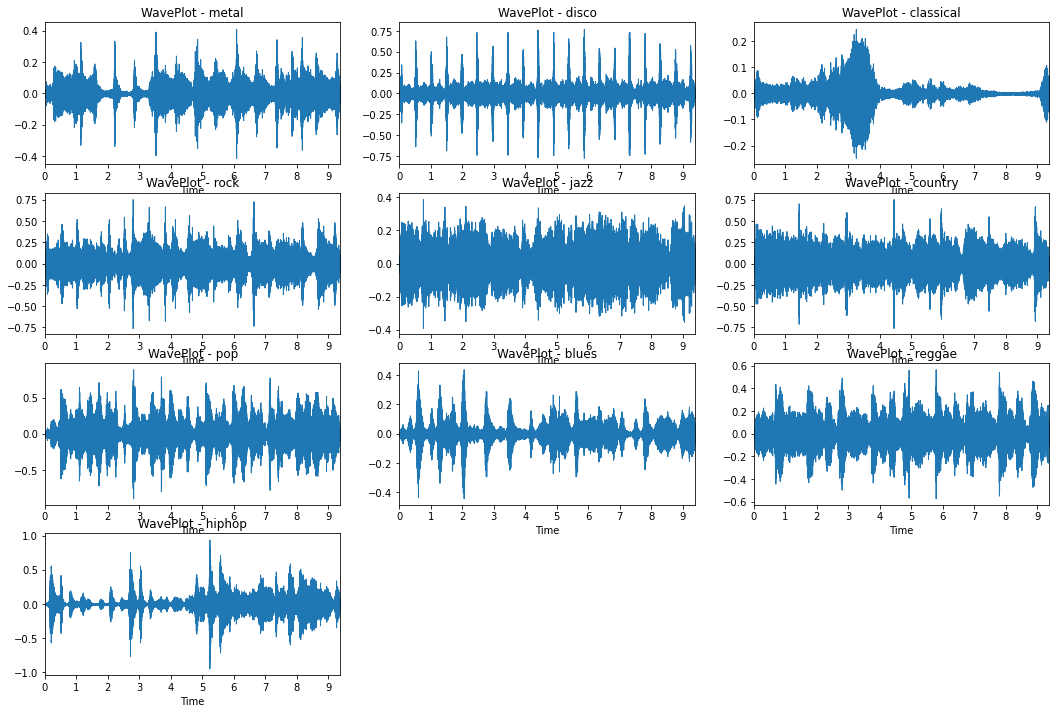

[DEBUG] TOTAL Number of Trainable Weights for model: 302337
Reconstructed Output:  (10, 28160, 1)
X':  [ 0.00645075  0.00170643 -0.00125634 ... -0.01027283 -0.01481007
  0.00241398]
X range: [0.9061111211776733, -1.0537792444229126]


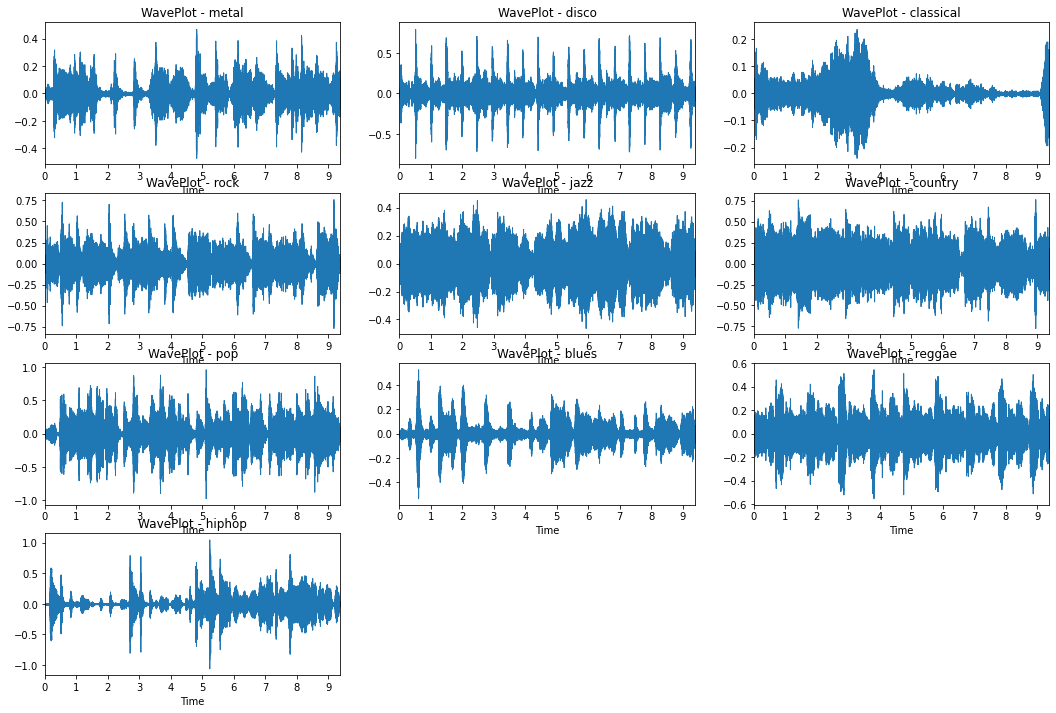

In [158]:
recon_train_samples_top_ = generate_and_save_waves(loaded_vqvae_trainer.vqvaes[1], 0, train_samples) #TODO: need to assign which level of vqvae...
recon_train_samples_bottom_ = generate_and_save_waves(loaded_vqvae_trainer.vqvaes[0], 0, train_samples) #TODO: need to assign which level of vqvae...

In [160]:
ipd.Audio(recon_train_samples_top_[2].squeeze(), rate=SAMPLE_RATE) # Metal Recon

In [161]:
ipd.Audio(recon_train_samples_bottom_[2].squeeze(), rate=SAMPLE_RATE) # Metal Recon

#### DEBUG SCRATCH....

In [ ]:
## VQ DEBUG
# N_t (latest value)
usage = vqvae_trainer.vq.get_usage_count()
codebook = vqvae_trainer.vq.embeddings
active_code = tf.reduce_sum(tf.cast(usage >= 1.0, dtype=tf.int32))
# print(usage)
# print(usage >= 1.0)
print(active_code)
## Important, N_t entries could turn zero -> NAN
print(usage == 0.0)
print(tf.reduce_max(codebook), tf.reduce_min(codebook))

tf.Tensor(512, shape=(), dtype=int32)
tf.Tensor(
[False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 F

In [ ]:
vqvae_trainer.vq.m_t

<tf.Variable 'Variable:0' shape=(64, 512) dtype=float32, numpy=
array([[  5.917916  , -10.428174  ,   9.5967245 , ...,  16.04785   ,
          5.4423156 ,  -6.365307  ],
       [ -2.37185   ,   4.3051944 ,  21.027668  , ...,   0.87258095,
        -27.030893  , -16.316456  ],
       [  8.320819  ,  -2.4206479 ,   1.0291103 , ..., -11.435529  ,
          2.148644  ,  15.238214  ],
       ...,
       [ -2.635304  ,   6.1512427 ,   5.6226254 , ...,  -4.8901625 ,
         12.239863  ,  20.60105   ],
       [ -5.440274  ,  19.265429  , -13.524259  , ...,   2.8909404 ,
        -14.686245  , -50.003235  ],
       [ -2.5005794 ,   6.6334925 ,  13.349167  , ...,   9.194157  ,
         -6.9985776 ,   5.5838437 ]], dtype=float32)>

In [ ]:
{m.name:m.result() for m in vqvae_trainer.vq.metrics}

{'batch_codebook_usage': <tf.Tensor: shape=(), dtype=float32, numpy=128.2907>,
 'codebook_usage': <tf.Tensor: shape=(), dtype=float32, numpy=133.46277>,
 'codebook_entropy': <tf.Tensor: shape=(), dtype=float32, numpy=3.8607996>}

In [ ]:
vqvae_trainer.vqvae.losses
vqvae_trainer.vq.losses
vqvae_trainer.vq.trainable_variables

[]

In [ ]:
m1 = tf.keras.metrics.Mean()
m1.update_state([4.0, 3.0])
m1.result()

<tf.Tensor: shape=(), dtype=float32, numpy=3.5>

In [ ]:
m1.update_state([2])
m1.result()

<tf.Tensor: shape=(), dtype=float32, numpy=3.0>

array([[-0.04690116],
       [-0.01698253],
       [-0.0486879 ],
       ...,
       [-0.00471123],
       [-0.02285618],
       [-0.06057921]], dtype=float32)

#### Spectral Loss

In [ ]:
stft_args = [(2048,1024,512), # n_fft
             (240, 120, 50), # hop_length
             (1200, 600, 240) # window_size
            ]

In [ ]:
train_samples[0].shape

(28160, 1)

In [ ]:
stft_test = tf.signal.stft(train_samples[0].squeeze(), frame_length=1200, frame_step=240, fft_length=2048)

In [ ]:
stft_test.shape

TensorShape([113, 1025])

In [ ]:
losses = []
for n_fft, hop_len, window_size in zip(*stft_args):
  print(n_fft, hop_len, window_size)
  stft = tf.signal.stft(train_samples.squeeze(), frame_length=window_size, frame_step=hop_len, fft_length=n_fft)
  print(stft.shape)
  print(stft[0][0][0])
  # # 1. 2-norm along FFT bins
  # a = tf.norm(stft, ord=2, axis=-1)
  # print(a.shape)
  # 2. sum of l2-norm
  # bs = tf.sqrt(tf.reduce_sum(tf.reshape(stft, [tf.shape(stft)[0], -1]) ** 2, axis=-1))
  bs = tf.norm(stft, ord='fro', axis=[-2, -1])
  print(bs.shape)
  print(bs)
  losses.append(bs)


2048 240 1200
(10, 113, 1025)
tf.Tensor((-2.2446992+0j), shape=(), dtype=complex64)
(10,)
tf.Tensor(
[ 535.9741 -4.1104638e-08j  863.6957 -6.6737385e-09j
  270.77917-5.0443528e-08j 1055.3267 +3.5604099e-08j
  963.7457 +8.9280725e-08j 1386.4645 +3.4946527e-08j
 1391.542  -4.7576059e-08j  533.52655-2.4971380e-08j
  943.2973 +1.9882150e-07j  896.8579 -2.9614961e-08j], shape=(10,), dtype=complex64)
1024 120 600
(10, 230, 513)
tf.Tensor((-1.1187711+0j), shape=(), dtype=complex64)
(10,)
tf.Tensor(
[381.94833-5.9286775e-10j 620.5952 -6.6862896e-08j
 194.82076+6.0407017e-09j 755.87933-2.0531434e-08j
 687.70184+7.3467703e-08j 989.5551 -8.5878547e-08j
 986.8614 +3.5598234e-08j 379.50098+7.7188865e-08j
 670.133  -1.4540102e-07j 641.86176+9.4090460e-08j], shape=(10,), dtype=complex64)
512 50 240
(10, 559, 257)
tf.Tensor((-0.47941685+0j), shape=(), dtype=complex64)
(10,)
tf.Tensor(
[266.11816-2.3722915e-10j 434.62277-2.7497755e-08j
 139.2142 -1.1551864e-08j 527.7472 +2.9795277e-08j
 479.64273+1.715

In [ ]:
combined_losses = tf.stack(losses, axis=1)

In [ ]:
losses

[<tf.Tensor: shape=(10,), dtype=complex64, numpy=
 array([ 535.9741 -4.1104638e-08j,  863.6957 -6.6737385e-09j,
         270.77917-5.0443528e-08j, 1055.3267 +3.5604099e-08j,
         963.7457 +8.9280725e-08j, 1386.4645 +3.4946527e-08j,
        1391.542  -4.7576059e-08j,  533.52655-2.4971380e-08j,
         943.2973 +1.9882150e-07j,  896.8579 -2.9614961e-08j],
       dtype=complex64)>,
 <tf.Tensor: shape=(10,), dtype=complex64, numpy=
 array([381.94833-5.9286775e-10j, 620.5952 -6.6862896e-08j,
        194.82076+6.0407017e-09j, 755.87933-2.0531434e-08j,
        687.70184+7.3467703e-08j, 989.5551 -8.5878547e-08j,
        986.8614 +3.5598234e-08j, 379.50098+7.7188865e-08j,
        670.133  -1.4540102e-07j, 641.86176+9.4090460e-08j],
       dtype=complex64)>,
 <tf.Tensor: shape=(10,), dtype=complex64, numpy=
 array([266.11816-2.3722915e-10j, 434.62277-2.7497755e-08j,
        139.2142 -1.1551864e-08j, 527.7472 +2.9795277e-08j,
        479.64273+1.7151669e-08j, 690.0339 +3.1279416e-08j,
      

In [ ]:
combined_losses

<tf.Tensor: shape=(10, 3), dtype=complex64, numpy=
array([[15.993887   +1.2128729j , 11.187222   -3.2378838j ,
         6.8226233  -0.41097903j],
       [27.52496   -10.888129j  , 14.366113   +5.2611513j ,
         0.33233923 -0.24584274j],
       [ 0.75910074 -8.758295j  ,  5.385035   +0.30067587j,
         1.3859464  -0.10178527j],
       [27.586338   -1.0997157j ,  8.152211  +16.072992j  ,
         0.43935797 -0.29275435j],
       [20.969154  -19.760118j  , 19.799353  +10.777251j  ,
        12.182803   -0.723784j  ],
       [41.75462   -43.19189j   ,  2.7872322 -49.062405j  ,
         4.0346727  -0.3109098j ],
       [ 5.7451477 +31.623487j  ,  5.9932275 -19.412903j  ,
         1.5107394  -0.5797067j ],
       [ 9.955629   +0.68163776j, 13.268803   -1.3105104j ,
         4.28145    -0.29128093j],
       [12.626544  +19.023083j  ,  2.7206552 -18.066181j  ,
         0.5639547  -0.1812262j ],
       [ 2.8487294 +21.812178j  , 16.452282   +0.5657174j ,
         1.245814   -0.73051643j]]

In [ ]:
tf.reduce_mean(combined_losses, axis=-1)

<tf.Tensor: shape=(10,), dtype=complex64, numpy=
array([11.334578  -0.8119967j , 14.0744705 -1.957607j  ,
        2.5100274 -2.8531349j , 12.059302  +4.8935075j ,
       17.650438  -3.2355506j , 16.192175 -30.85507j   ,
        4.4163713 +3.8769593j ,  9.168628  -0.30671787j,
        5.303718  +0.25855845j,  6.848942  +7.215793j  ], dtype=complex64)>